In [1]:
#fetch command line argument (prepped model)
#%reset
import sys
import os
from copy import deepcopy
import pickle
import torch
import plotly.offline as py
import plotly.graph_objs as go


sys.path.insert(0, os.path.abspath('./prep_model_scripts/'))
sys.path.insert(0, os.path.abspath('./visualizer_scripts/'))
from visualizer_helper_functions import *
from contrast_helper_functions import *
from featureviz_helper_functions import *
from subgraph_helper_functions import *
from ablation_functions import *
from receptive_field import *
from dissected_Conv2d import *
from copy import deepcopy


py.init_notebook_mode(connected=True)   #jupyter notebook only

prepped_model_folder = 'alexnet_sparse'    #set this to a subfolder of prunned_models

full_prepped_model_folder = os.path.abspath('prepped_models/%s'%prepped_model_folder)

possible_models = os.listdir('prepped_models')
print('possible models to visualizer are:')
print(possible_models)

print('\nYou\'ve chosen to visualize %s'%prepped_model_folder)


sys.path.insert(0,'prepped_models/%s'%prepped_model_folder)

import prep_model_params_used as prep_model_params

params = {}
params['prepped_model'] = prepped_model_folder
params['prepped_model_path'] = full_prepped_model_folder
params['device'] = 'cuda:2'
params['deepviz_neuron'] = True
params['deepviz_edge'] = False


#Parameters

#Non-GUI parameters

#deepviz
params['deepviz_param'] = None
params['deepviz_optim'] = None
params['deepviz_transforms'] = None
params['deepviz_image_size'] = prep_model_params.deepviz_image_size

#backend
params['cuda'] = prep_model_params.cuda    #use gpu acceleration when running model forward
params['input_image_directory'] = prep_model_params.input_img_path+'/'   #path to directory of imput images you want fed through the network
params['preprocess'] = prep_model_params.preprocess     #torchvision transfrom to pass input images through
params['label_file_path'] = prep_model_params.label_file_path
params['criterion'] = prep_model_params.criterion
params['rank_img_path'] = prep_model_params.rank_img_path
params['num_workers'] = prep_model_params.num_workers
params['seed'] = prep_model_params.seed
params['batch_size'] = prep_model_params.batch_size
#params['dynamic_act_cache_num'] = 4  #max number of input image activations 'dynamic_activations' will have simultaneously


#load misc graph data
print('loading misc graph data')
misc_data = pickle.load(open('./prepped_models/%s/misc_graph_data.pkl'%prepped_model_folder,'rb'))
params['layer_nodes'] = misc_data['layer_nodes']
params['num_layers'] = misc_data['num_layers']
params['num_nodes'] = misc_data['num_nodes']
params['categories'] = misc_data['categories']
params['num_img_chan'] = misc_data['num_img_chan']
params['imgnode_positions'] = misc_data['imgnode_positions']
params['imgnode_colors'] = misc_data['imgnode_colors']
params['imgnode_names'] = misc_data['imgnode_names']
params['prepped_model_path'] = full_prepped_model_folder
params['ranks_data_path'] = full_prepped_model_folder+'/ranks/'



ModuleNotFoundError: No module named 'visualizer_helper_functions'

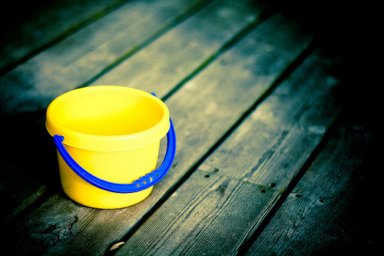

In [18]:
params['input_image_directory']
img = Image.open('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/input_images/bucket_15846.JPEG')
display(img)

In [2]:
def unravel_index(indices,shape):
    r"""Converts flat indices into unraveled coordinates in a target shape.

    This is a `torch` implementation of `numpy.unravel_index`.

    Args:
        indices: A tensor of (flat) indices, (*, N).
        shape: The targeted shape, (D,).

    Returns:
        The unraveled coordinates, (*, N, D).
    """

    coord = []

    for dim in reversed(shape):
        coord.append(indices % dim)
        indices = indices // dim

    coord = torch.stack(coord[::-1], dim=-1)

    return coord

In [3]:
model = prep_model_params.model
model = model.eval().to(params['device'])

/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning:


Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/




In [4]:
from random import shuffle
import os
input_image_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/unsorted_ranking_images'
image_names = os.listdir(input_image_folder)
shuffle(image_names)



In [5]:
from copy import deepcopy
sorted_image_names = deepcopy(image_names)
sorted_image_names.sort()

In [6]:
max_activations = {'image_folder':input_image_folder,'layer':{}}

In [7]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().to('cpu')
    return hook

count = 0
for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(get_activation('conv'+str(count)))
        max_activations['layer']['conv'+str(count)] = {}
        count+=1

## Gen span Activations

In [ ]:
'''
max activations stores data for each feature in each layer as a list of lists, where each list has elements
[
index of image (supposing all images in the used image folder are sorted alphebetically)
w index of activation in feature map,
h index of activation in feature map,
activation value
]
'''


import time

batch_size = 250

for batch_i in range(int(len(image_names)/batch_size)):
    start = time.time()
    image_batch = None
    print('%s/%s'%(str(batch_i),str(int(len(image_names)/batch_size))))
    for image_name in image_names[batch_i*batch_size:batch_i*batch_size+batch_size]:   
        processed_image = preprocess_image(input_image_folder+'/'+image_name,params)
        if image_batch is None:
            image_batch = processed_image
        else:
            image_batch = torch.cat((image_batch,processed_image))
    activations = {}
    output = model(image_batch)
    for layer in activations:
        for f in range(activations[layer].shape[1]):
            indices = unravel_index(torch.argmax(activations[layer][:,f,:,:]),activations[layer][:,f,:,:].shape).to('cpu')
            value = activations[layer][indices[0],f,indices[1],indices[2]]
            value2 = torch.max(activations[layer][:,f,:,:])
            if value != value2:
                print(value)
                print(value2)
                raise Exception('error value check not passed!')
            if f not in max_activations['layer'][layer].keys():
                max_activations['layer'][layer][f] = [[sorted_image_names.index(image_names[batch_i*batch_size:batch_i*batch_size+batch_size][int(indices[0])]),int(indices[1]),int(indices[2]),np.float16(value)]]
            else:
                max_activations['layer'][layer][f].append([sorted_image_names.index(image_names[batch_i*batch_size:batch_i*batch_size+batch_size][int(indices[0])]),int(indices[1]),int(indices[2]),np.float16(value)])
    print(time.time() - start)

In [1]:
max_activations['layer']['conv1']['activations'][0]

NameError: name 'max_activations' is not defined

In [ ]:
#slooooowww

max_activations_nodup = {'image_folder':input_image_folder,'layer':{}}

for layer in max_activations['layer']:
    print(layer)
    max_activations_nodup['layer'][layer] = {'image_patches':[],'activations':[]}
    for i,e in enumerate(max_activations['layer'][layer]['image_patches']):
        if e not in max_activations_nodup['layer'][layer]['image_patches']:
            max_activations_nodup['layer'][layer]['image_patches'].append(e)
            max_activations_nodup['layer'][layer]['activations'].append(max_activations['layer'][layer]['activations'][i])
                                                                        

In [ ]:
#duplicates eliminated

for layer in max_activations['layer']:
    print(layer)
    print(len(max_activations['layer'][layer]['image_patches'])-len(max_activations_nodup['layer'][layer]['image_patches']))

In [ ]:
#double check, this should return nothing


def duplicates(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

dict((x, duplicates(max_activations_nodup['layer']['conv1']['image_patches'], x)) for x in set(max_activations_nodup['layer']['conv1']['image_patches']) if max_activations['layer']['conv1']['image_patches'].count(x) > 1)

In [ ]:
# import pickle
# pickle.dump(max_activations,open('max_activation_patches.pkl','wb'))

## gen max activations

In [8]:
from random import shuffle
import os
from copy import deepcopy

batch_size = 1000
input_image_folder = '/mnt/data/datasets/imagenet/all_images/'

image_names = os.listdir(input_image_folder)
image_names.sort()

#image_names = deepcopy(image_names_sorted)
#shuffle(image_names)


max_activations = {'image_folder':input_image_folder,'layer':{}}

'''
max activations stores for each layer (the names of which are the dictionary keys) 
2 numpy arrays of shape [num_images,num_features] and [num_images,num_features,2]

the first array stores maximum activation values for each feature on each image (images are sorted alphebetically)
the second array store the w,h indices for these maximum activations

'''


import time



for batch_i in range(int(len(image_names)/batch_size)):
    start = time.time()
    image_batch = None
    print('%s/%s'%(str(batch_i),str(int(len(image_names)/batch_size))))
    for image_name in image_names[batch_i*batch_size:batch_i*batch_size+batch_size]:   
        processed_image = preprocess_image(input_image_folder+'/'+image_name,params)
        if image_batch is None:
            image_batch = processed_image
        else:
            image_batch = torch.cat((image_batch,processed_image))
    activations = {}
    output = model(image_batch)
    for layer in activations:
        acts = activations[layer]
        acts_max = acts.view(acts.size(0),acts.size(1), acts.size(2)*acts.size(3)).max(dim=-1)
        indices = unravel_index(acts_max.indices,torch.Size([int(acts.size(2)),int(acts.size(3))]))
        if layer not in max_activations['layer'].keys():
            max_activations['layer'][layer] = [acts_max.values.numpy().astype('float16'),indices.numpy().astype('int8')]
        else:
            max_activations['layer'][layer][0] = np.concatenate((max_activations['layer'][layer][0],acts_max.values.numpy().astype('float16')))
            max_activations['layer'][layer][1] = np.concatenate((max_activations['layer'][layer][1],indices.numpy().astype('int8')))
    print(time.time() - start)

pickle.dump(max_activations,open('prepped_models/alexnet_sparse/misc_data/all_max_activations.pkl','wb'))

0/1331


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
#import pickle
#pickle.dump(max_activations,open('max_activation_1000patches.pkl','wb'))

## Gen Min activations 

In [29]:
from random import shuffle
import os
from copy import deepcopy

batch_size = 1000
input_image_folder = '/mnt/data/datasets/imagenet/all_images/'

image_names = os.listdir(input_image_folder)
image_names.sort()

#image_names = deepcopy(image_names_sorted)
#shuffle(image_names)


min_activations = {'image_folder':input_image_folder,'layer':{}}

'''
min activations stores for each layer (the names of which are the dictionary keys) 
2 numpy arrays of shape [num_images,num_features] and [num_images,num_features,2]

the first array stores minimum activation values for each feature on each image (images are sorted alphebetically)
the second array store the w,h indices for these minimum activations

'''


import time

for batch_i in range(int(len(image_names)/batch_size)):
    start = time.time()
    image_batch = None
    print('%s/%s'%(str(batch_i),str(int(len(image_names)/batch_size))))
    for image_name in image_names[batch_i*batch_size:batch_i*batch_size+batch_size]:   
        processed_image = preprocess_image(input_image_folder+'/'+image_name,params)
        if image_batch is None:
            image_batch = processed_image
        else:
            image_batch = torch.cat((image_batch,processed_image))
    activations = {}
    output = model(image_batch)
    for layer in activations:
        acts = activations[layer]
        acts_min = acts.view(acts.size(0),acts.size(1), acts.size(2)*acts.size(3)).min(dim=-1)
        indices = unravel_index(acts_min.indices,torch.Size([int(acts.size(2)),int(acts.size(3))]))
        if layer not in min_activations['layer'].keys():
            min_activations['layer'][layer] = [acts_min.values.numpy().astype('float16'),indices.numpy().astype('int8')]
        else:
            min_activations['layer'][layer][0] = np.concatenate((min_activations['layer'][layer][0],acts_min.values.numpy().astype('float16')))
            min_activations['layer'][layer][1] = np.concatenate((min_activations['layer'][layer][1],indices.numpy().astype('int8')))
    print(time.time() - start)

pickle.dump(min_activations,open('prepped_models/alexnet_sparse/misc_data/all_min_activations.pkl','wb'))

0/1331
7.63544487953186
1/1331
5.707641839981079
2/1331
6.73072361946106
3/1331
7.254543781280518
4/1331
6.4294939041137695
5/1331
6.320057153701782
6/1331
6.5167810916900635
7/1331
6.462991952896118
8/1331
6.470990896224976
9/1331
6.3910346031188965
10/1331
6.515806198120117
11/1331
7.092221975326538
12/1331
6.807905435562134
13/1331
6.7477264404296875
14/1331
7.255808115005493
15/1331
6.630923509597778
16/1331
6.622047185897827
17/1331
6.82924485206604
18/1331
6.772309303283691
19/1331
6.173486948013306
20/1331
6.42636775970459
21/1331
6.402098894119263
22/1331
6.342310667037964
23/1331
6.368427038192749
24/1331
6.5111541748046875
25/1331
6.421175956726074
26/1331
5.944039821624756
27/1331
6.192673444747925
28/1331
6.343834161758423
29/1331
6.184320449829102
30/1331
6.390782117843628
31/1331
6.5227437019348145
32/1331
6.477313041687012
33/1331
6.566454648971558
34/1331
6.28272819519043
35/1331
6.180675029754639
36/1331
6.078529596328735
37/1331
6.346601724624634
38/1331
6.29750466346

7.270398139953613
309/1331
7.148386716842651
310/1331
7.206135272979736
311/1331
7.226423025131226
312/1331
6.086625576019287
313/1331
6.913722991943359
314/1331
7.191549062728882
315/1331
7.129809856414795
316/1331
7.373244762420654
317/1331
7.428424119949341
318/1331
7.127854585647583
319/1331
6.858096599578857
320/1331
6.960188150405884
321/1331
6.676532745361328
322/1331
6.974327325820923
323/1331
7.133442401885986
324/1331
6.588012456893921
325/1331
7.020162343978882
326/1331
6.018991947174072
327/1331
6.7864954471588135
328/1331
7.142924070358276
329/1331
6.998075008392334
330/1331
6.928894519805908
331/1331
7.053445816040039
332/1331
6.553381443023682
333/1331
6.520397424697876
334/1331
6.705660581588745
335/1331
6.934252977371216
336/1331
7.0663535594940186
337/1331
6.879339218139648
338/1331
6.923309803009033
339/1331
7.16821551322937
340/1331
6.068169355392456
341/1331
6.465115070343018
342/1331
6.208442449569702
343/1331
6.7302916049957275
344/1331
6.650904178619385
345/1331

7.070154428482056
613/1331
9.92676305770874
614/1331
7.494247913360596
615/1331
6.983619689941406
616/1331
7.206924915313721
617/1331
7.929379463195801
618/1331
7.378971338272095
619/1331
7.499000310897827
620/1331
8.045897006988525
621/1331
7.475388288497925
622/1331
7.6869823932647705
623/1331
7.954214811325073
624/1331
7.238947629928589
625/1331
8.501274824142456
626/1331
7.95839524269104
627/1331
7.304179430007935
628/1331
7.992582082748413
629/1331
7.600174188613892
630/1331
7.700962543487549
631/1331
7.847062587738037
632/1331
7.985994815826416
633/1331
8.547197818756104
634/1331
8.022359609603882
635/1331
7.537216424942017
636/1331
7.237811803817749
637/1331
7.599406957626343
638/1331
7.766106605529785
639/1331
7.380894422531128
640/1331
6.878263473510742
641/1331
7.202512264251709
642/1331
7.240823745727539
643/1331
7.804264307022095
644/1331
8.15629506111145
645/1331
7.987820386886597
646/1331
7.450732469558716
647/1331
7.414716958999634
648/1331
7.466794490814209
649/1331
7.2

8.234133958816528
918/1331
8.217562437057495
919/1331
8.136290788650513
920/1331
8.535820722579956
921/1331
8.128621101379395
922/1331
7.364863872528076
923/1331
7.535697937011719
924/1331
7.48964786529541
925/1331
7.435665607452393
926/1331
7.3355491161346436
927/1331
7.162795305252075
928/1331
7.915586948394775
929/1331
8.033914804458618
930/1331
7.7320473194122314
931/1331
7.455000162124634
932/1331
7.602531909942627
933/1331
7.574849367141724
934/1331
7.699504852294922
935/1331
7.721073150634766
936/1331
7.469878673553467
937/1331
7.854371786117554
938/1331
7.610558032989502
939/1331
7.578665256500244
940/1331
8.115123510360718
941/1331
7.965839862823486
942/1331
8.280848026275635
943/1331
7.969101667404175
944/1331
7.516344785690308
945/1331
7.268208980560303
946/1331
7.561649322509766
947/1331
7.8271098136901855
948/1331
8.324970960617065
949/1331
8.655571699142456
950/1331
8.255159378051758
951/1331
8.176214933395386
952/1331
7.363260984420776
953/1331
7.654978513717651
954/1331

8.203325033187866
1214/1331
8.455653429031372
1215/1331
8.505236148834229
1216/1331
11.517257452011108
1217/1331
8.895659685134888
1218/1331
9.341137647628784
1219/1331
11.27599287033081
1220/1331
10.730742454528809
1221/1331
10.143470525741577
1222/1331
11.4737229347229
1223/1331
8.494858980178833
1224/1331
10.640254259109497
1225/1331
7.857278823852539
1226/1331
8.304097652435303
1227/1331
8.300916194915771
1228/1331
8.411599397659302
1229/1331
8.149728775024414
1230/1331
8.195850133895874
1231/1331
8.974584102630615
1232/1331
10.849740028381348
1233/1331
10.615217924118042
1234/1331
10.322223663330078
1235/1331
10.564958572387695
1236/1331
10.54758906364441
1237/1331
10.151267766952515
1238/1331
7.944072484970093
1239/1331
8.54328989982605
1240/1331
8.599712133407593
1241/1331
8.324600458145142
1242/1331
8.792975187301636
1243/1331
7.736600637435913
1244/1331
8.625484466552734
1245/1331
8.96660327911377
1246/1331
9.238462686538696
1247/1331
7.950981378555298
1248/1331
8.195360660552

## find activations withinepsilon of another

## Load Max activations from Save

In [8]:
import pickle

#max_activations = pickle.load(open('max_activation_patches.pkl','rb'))
max_activations = pickle.load(open('prepped_models/alexnet_sparse/misc_data/all_max_activations.pkl','rb'))

import os
image_names = os.listdir(max_activations['image_folder'])
image_names.sort()

In [9]:
name_dict = gen_conv_name_dict(model)

In [10]:
receptive_fields = None
if os.path.exists('prepped_models/%s/receptive_fields.pkl'%prepped_model_folder):
    receptive_fields = pickle.load(open('prepped_models/%s/receptive_fields.pkl'%prepped_model_folder,'rb'))
     

        

In [11]:
from PIL import Image
from torchvision import transforms


def display_image_patch_for_activation(image_path,layer_name,position,params,simple_name=True,frame = True, save=False):
    '''
    image_path -> full path to image
    layer_name -> name of reference layer for activation map (can be a layer name based on _ convention or simple 'conv1' convention)
    position -> a tuple (w,h) of position in activation map for which image patch is the receptive field
    simple_name -> set to true if using 'conv1' 'conv2' naming convention, False otherwise
    '''
    if simple_name:
        name_dict = gen_conv_name_dict(model)
        layer_name = name_dict[layer_name]
    recep_field = receptive_field_for_unit(receptive_fields, layer_name, position)
    
    image = Image.open(image_path)
    #display(image)
    resize_2_tensor = transforms.Compose([transforms.Resize((params['deepviz_image_size'],params['deepviz_image_size'])),transforms.ToTensor()])
    tensor_image = resize_2_tensor(image)
    rand_tensor = torch.zeros(3,params['deepviz_image_size'],params['deepviz_image_size'])
    cropped_tensor_image = tensor_image[:,int(recep_field[0][0]):int(recep_field[0][1]),int(recep_field[1][0]):int(recep_field[1][1])]
    rand_tensor[:,int(recep_field[0][0]):int(recep_field[0][1]),int(recep_field[1][0]):int(recep_field[1][1])] = cropped_tensor_image
    if frame:
        cropped_image = transforms.ToPILImage()(rand_tensor).convert("RGB")
    else:    
        cropped_image = transforms.ToPILImage()(cropped_tensor_image).convert("RGB")
    
    if save:
        cropped_image.save(save)
    else:
        display(cropped_image)
    
 

def run_cropped_image_patch_for_activation(model,image_path,layer_name,within_layer_id,position,params,simple_name=True):
    '''
    image_path -> full path to image
    layer_name -> name of reference layer for activation map (can be a layer name based on _ convention or simple 'conv1' convention)
    position -> a tuple (w,h) of position in activation map for which image patch is the receptive field
    simple_name -> set to true if using 'conv1' 'conv2' naming convention, False otherwise
    '''
    if simple_name:
        name_dict = gen_conv_name_dict(model)
        layer_name = name_dict[layer_name]
    recep_field = receptive_field_for_unit(receptive_fields, layer_name, position)

 
    tensor_image = preprocess_image(image_path,params)
    rand_tensor = torch.zeros(1,3,params['deepviz_image_size'],params['deepviz_image_size'])
    cropped_tensor_image = tensor_image[:,:,int(recep_field[0][0]):int(recep_field[0][1]),int(recep_field[1][0]):int(recep_field[1][1])]
    rand_tensor[:,:,int(recep_field[0][0]):int(recep_field[0][1]),int(recep_field[1][0]):int(recep_field[1][1])] = cropped_tensor_image
    rand_tensor = rand_tensor.to(params['device'])
    output = model(rand_tensor)


## Display top images

UNIT: 44
44


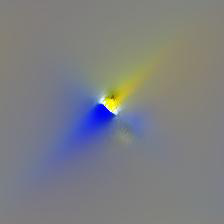

tensor(50.0734)
activation:tensor(47.5938, dtype=torch.float64)
binder_16464.JPEG


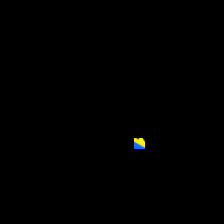

activation:tensor(47.1562, dtype=torch.float64)
swing_13164.JPEG


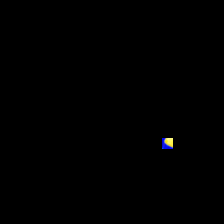

activation:tensor(46.4375, dtype=torch.float64)
bucket_15846.JPEG


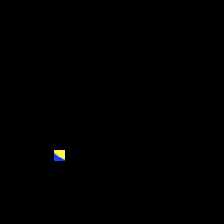

activation:tensor(44.9688, dtype=torch.float64)
pinwheel_6852.JPEG


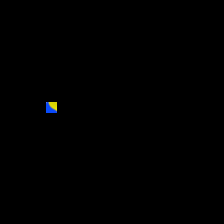

activation:tensor(44.6250, dtype=torch.float64)
umbrella_8766.JPEG


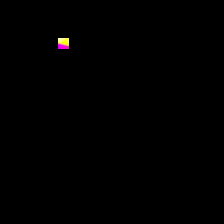

activation:tensor(44.1875, dtype=torch.float64)
soccer_ball_2637.JPEG


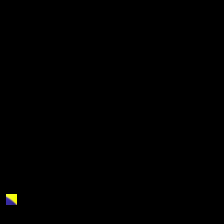

activation:tensor(43.6562, dtype=torch.float64)
piggy_bank_5021.JPEG


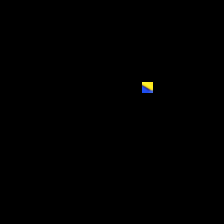

activation:tensor(43.6250, dtype=torch.float64)
jigsaw_puzzle_22945.JPEG


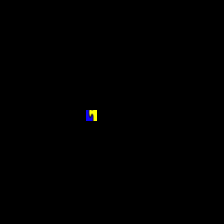

activation:tensor(42.5625, dtype=torch.float64)
comic_book_15030.JPEG


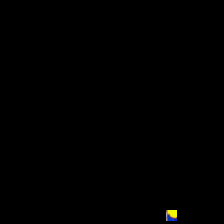

activation:tensor(42., dtype=torch.float64)
web_site_32672.JPEG


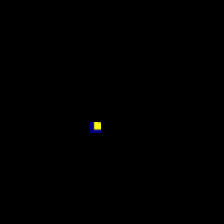

activation:tensor(42., dtype=torch.float64)
pick_10040.JPEG


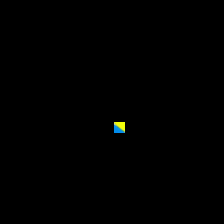

activation:tensor(41.5938, dtype=torch.float64)
swing_11685.JPEG


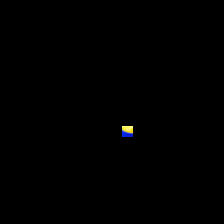

activation:tensor(41.1562, dtype=torch.float64)
pinwheel_10085.JPEG


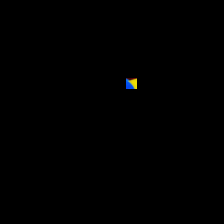

activation:tensor(40.7188, dtype=torch.float64)
scale_9214.JPEG


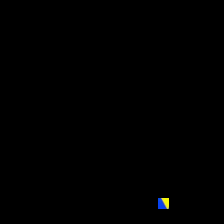

activation:tensor(40.1562, dtype=torch.float64)
pick_6765.JPEG


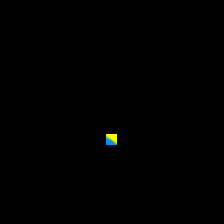

activation:tensor(40.1562, dtype=torch.float64)
scuba_diver_1065.JPEG


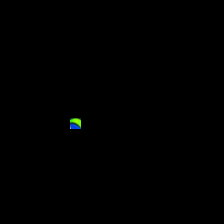

activation:tensor(40.1250, dtype=torch.float64)
jigsaw_puzzle_5725.JPEG


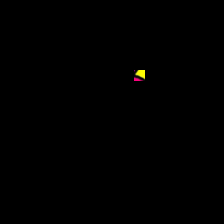

activation:tensor(40.1250, dtype=torch.float64)
screen_74233.JPEG


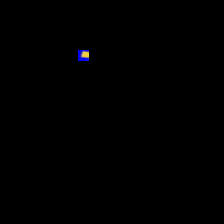

activation:tensor(39.9688, dtype=torch.float64)
daisy_51019.JPEG


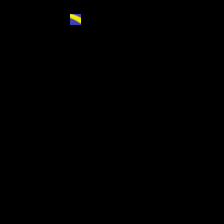

activation:tensor(39.8438, dtype=torch.float64)
parachute_30394.JPEG


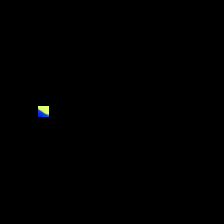

activation:tensor(39.7812, dtype=torch.float64)
screen_11901.JPEG


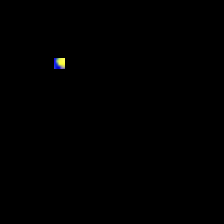

activation:tensor(39.7500, dtype=torch.float64)
digital_clock_9315.JPEG


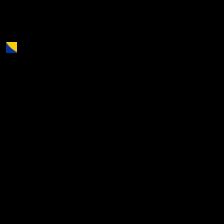

activation:tensor(39.6875, dtype=torch.float64)
soccer_ball_3334.JPEG


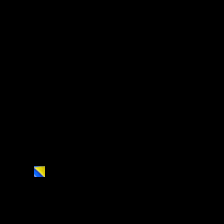

activation:tensor(39.5000, dtype=torch.float64)
parachute_33265.JPEG


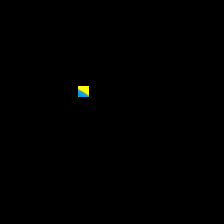

activation:tensor(39.3750, dtype=torch.float64)
bullet_train_15193.JPEG


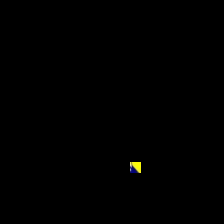

activation:tensor(39.3125, dtype=torch.float64)
shopping_basket_14227.JPEG


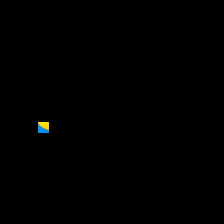

activation:tensor(39.2812, dtype=torch.float64)
tray_00000899.JPEG


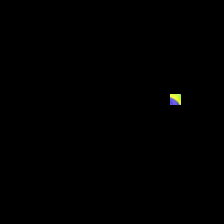

activation:tensor(39.2812, dtype=torch.float64)
umbrella_4754.JPEG


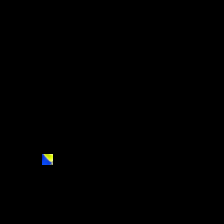

activation:tensor(39.1250, dtype=torch.float64)
hair_spray_33299.JPEG


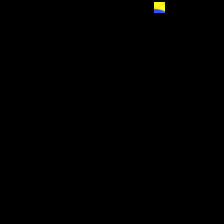

activation:tensor(39.0938, dtype=torch.float64)
volleyball_19087.JPEG


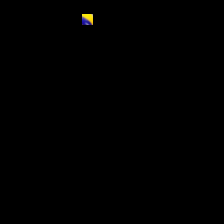

activation:tensor(39.0312, dtype=torch.float64)
basketball_13161.JPEG


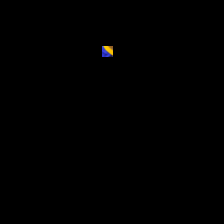

activation:tensor(38.9688, dtype=torch.float64)
rock_beauty_1906.JPEG


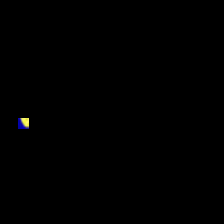

activation:tensor(38.9375, dtype=torch.float64)
gong_14268.JPEG


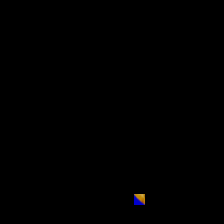

activation:tensor(38.8750, dtype=torch.float64)
comic_book_18532.JPEG


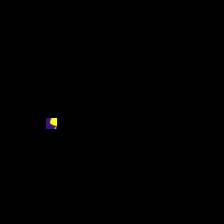

activation:tensor(38.8125, dtype=torch.float64)
neck_brace_00033894.JPEG


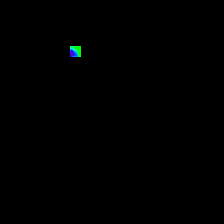

activation:tensor(38.7500, dtype=torch.float64)
packet_9137.JPEG


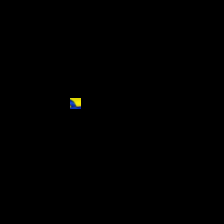

activation:tensor(38.5000, dtype=torch.float64)
Weimaraner_00023005.JPEG


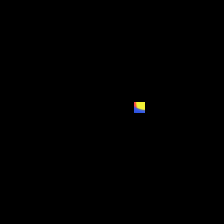

activation:tensor(38.4688, dtype=torch.float64)
mask_13006.JPEG


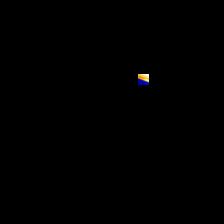

activation:tensor(38.4375, dtype=torch.float64)
television_2085.JPEG


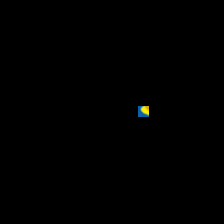

activation:tensor(38.4375, dtype=torch.float64)
pick_34568.JPEG


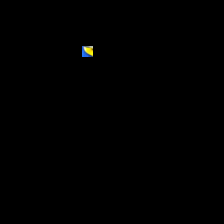

activation:tensor(38.4375, dtype=torch.float64)
plastic_bag_894.JPEG


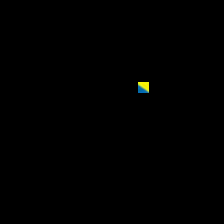

activation:tensor(38.4062, dtype=torch.float64)
joystick_12960.JPEG


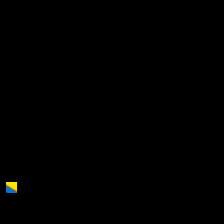

activation:tensor(38.3750, dtype=torch.float64)
lotion_4183.JPEG


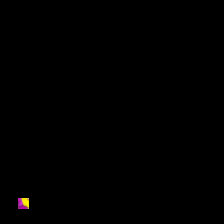

activation:tensor(38.2812, dtype=torch.float64)
volleyball_14004.JPEG


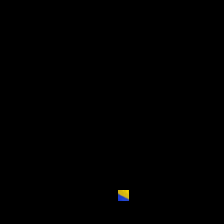

activation:tensor(38.2500, dtype=torch.float64)
rock_beauty_00048719.JPEG


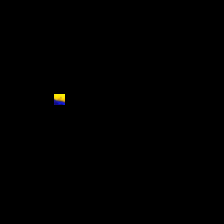

activation:tensor(38.2500, dtype=torch.float64)
barrel_00038485.JPEG


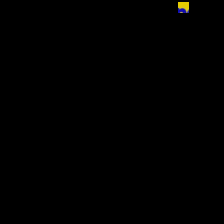

activation:tensor(38.1875, dtype=torch.float64)
comic_book_14085.JPEG


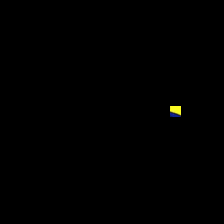

activation:tensor(38.1562, dtype=torch.float64)
slot_11269.JPEG


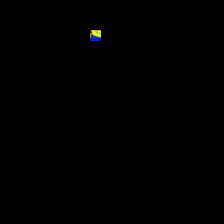

activation:tensor(38.0938, dtype=torch.float64)
jack_o_lantern_3630.JPEG


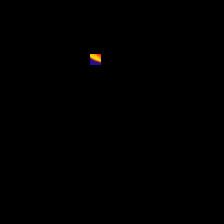

activation:tensor(38.0625, dtype=torch.float64)
ashcan_14123.JPEG


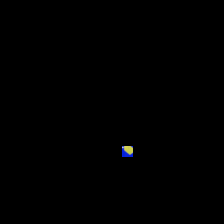

activation:tensor(38., dtype=torch.float64)
neck_brace_1139.JPEG


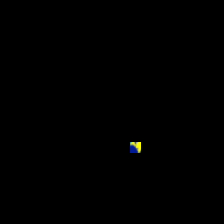

activation:tensor(37.9688, dtype=torch.float64)
balloon_4789.JPEG


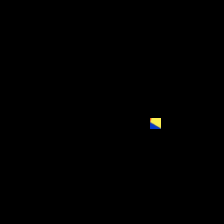

activation:tensor(37.9062, dtype=torch.float64)
passenger_car_80206.JPEG


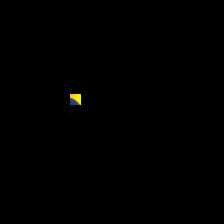

activation:tensor(37.8438, dtype=torch.float64)
soccer_ball_9479.JPEG


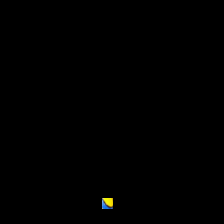

activation:tensor(37.8125, dtype=torch.float64)
damselfly_400.JPEG


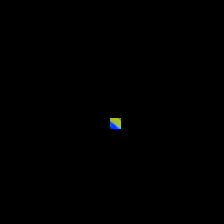

activation:tensor(37.7812, dtype=torch.float64)
orange_4352.JPEG


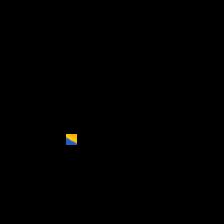

activation:tensor(37.7812, dtype=torch.float64)
rock_beauty_731.JPEG


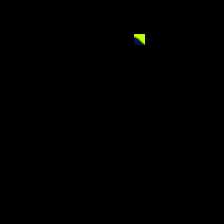

activation:tensor(37.7500, dtype=torch.float64)
nematode_2186.JPEG


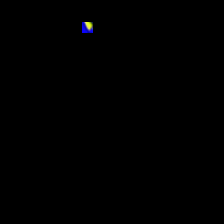

activation:tensor(37.6562, dtype=torch.float64)
envelope_4175.JPEG


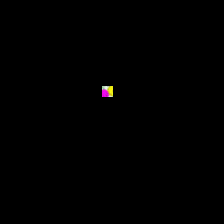

activation:tensor(37.5938, dtype=torch.float64)
speedboat_29426.JPEG


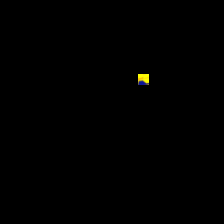

activation:tensor(37.5938, dtype=torch.float64)
groom_796.JPEG


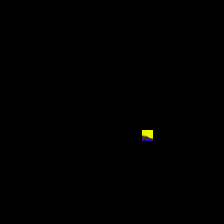

activation:tensor(37.5000, dtype=torch.float64)
slot_32660.JPEG


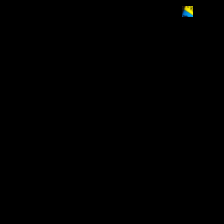

activation:tensor(37.5000, dtype=torch.float64)
racer_33621.JPEG


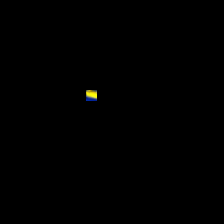

activation:tensor(37.4062, dtype=torch.float64)
go_kart_16053.JPEG


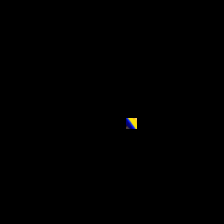

activation:tensor(37.4062, dtype=torch.float64)
comic_book_901.JPEG


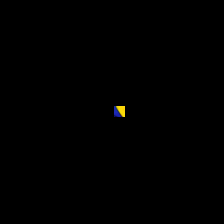

activation:tensor(37.3438, dtype=torch.float64)
swab_27920.JPEG


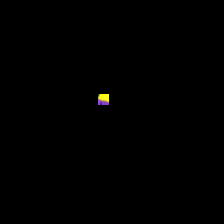

activation:tensor(37.2500, dtype=torch.float64)
hay_17427.JPEG


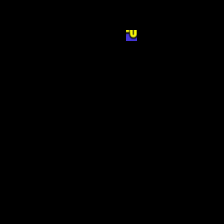

activation:tensor(37.0938, dtype=torch.float64)
accordion_33011.JPEG


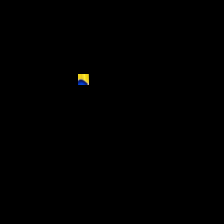

activation:tensor(37.0625, dtype=torch.float64)
monitor_2892.JPEG


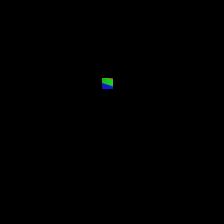

activation:tensor(37.0625, dtype=torch.float64)
slot_3659.JPEG


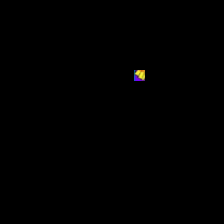

activation:tensor(37.0625, dtype=torch.float64)
slot_21034.JPEG


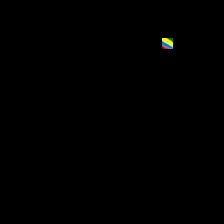

activation:tensor(37.0312, dtype=torch.float64)
bicycle_built_for_two_2625.JPEG


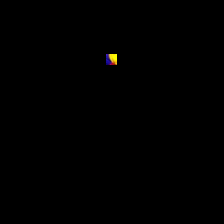

activation:tensor(37.0312, dtype=torch.float64)
swimming_trunks_3480.JPEG


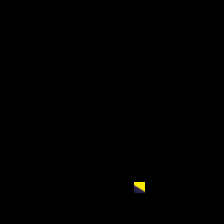

activation:tensor(37.0312, dtype=torch.float64)
Tibetan_mastiff_3771.JPEG


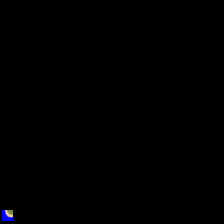

activation:tensor(37., dtype=torch.float64)
minibus_9432.JPEG


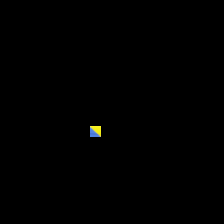

activation:tensor(37., dtype=torch.float64)
forklift_1532.JPEG


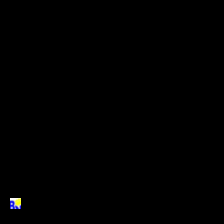

activation:tensor(36.9688, dtype=torch.float64)
gas_pump_8646.JPEG


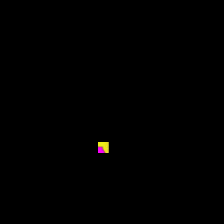

activation:tensor(36.9375, dtype=torch.float64)
sunglass_985.JPEG


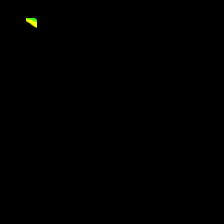

activation:tensor(36.9375, dtype=torch.float64)
ambulance_3209.JPEG


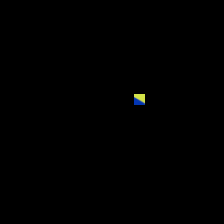

activation:tensor(36.8750, dtype=torch.float64)
macaw_3693.JPEG


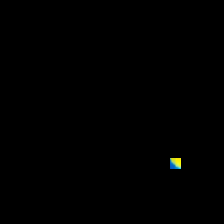

activation:tensor(36.8750, dtype=torch.float64)
volleyball_14131.JPEG


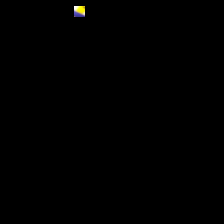

activation:tensor(36.8750, dtype=torch.float64)
anemone_fish_8221.JPEG


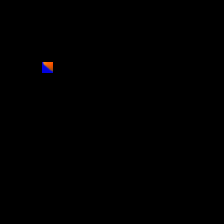

activation:tensor(36.8438, dtype=torch.float64)
confectionery_16159.JPEG


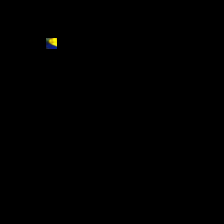

activation:tensor(36.8438, dtype=torch.float64)
beer_bottle_3276.JPEG


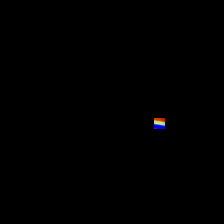

activation:tensor(36.7812, dtype=torch.float64)
table_lamp_3123.JPEG


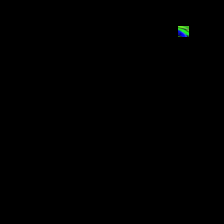

activation:tensor(36.7812, dtype=torch.float64)
basketball_7934.JPEG


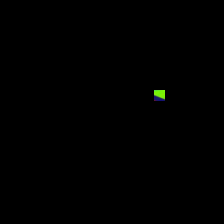

activation:tensor(36.7812, dtype=torch.float64)
tricycle_20849.JPEG


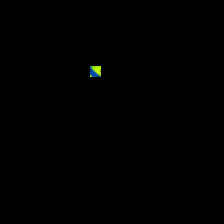

activation:tensor(36.7188, dtype=torch.float64)
confectionery_98697.JPEG


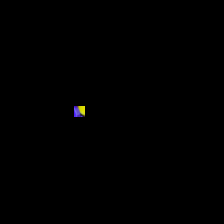

activation:tensor(36.6875, dtype=torch.float64)
snowmobile_00006217.JPEG


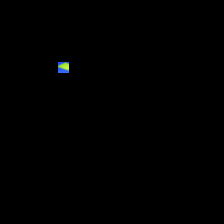

activation:tensor(36.6875, dtype=torch.float64)
jellyfish_9374.JPEG


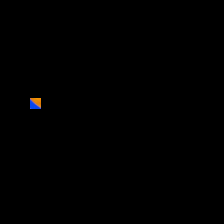

activation:tensor(36.6562, dtype=torch.float64)
traffic_light_23108.JPEG


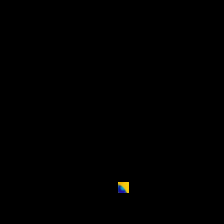

activation:tensor(36.5625, dtype=torch.float64)
cellular_telephone_18326.JPEG


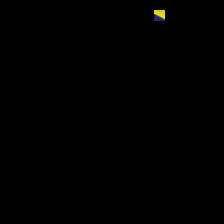

activation:tensor(36.5000, dtype=torch.float64)
sunscreen_15156.JPEG


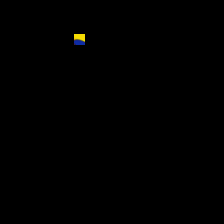

activation:tensor(36.4688, dtype=torch.float64)
bottlecap_159.JPEG


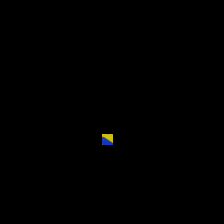

activation:tensor(36.4375, dtype=torch.float64)
electric_guitar_44.JPEG


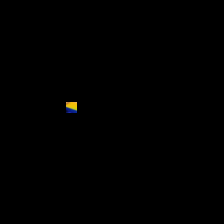

activation:tensor(36.4375, dtype=torch.float64)
clog_15986.JPEG


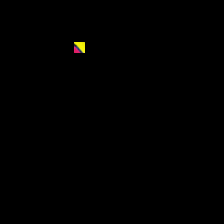

activation:tensor(36.4062, dtype=torch.float64)
grille_00041782.JPEG


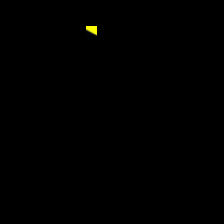

activation:tensor(36.3438, dtype=torch.float64)
spindle_2310.JPEG


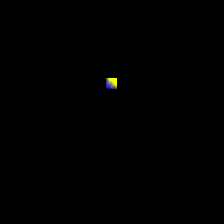

activation:tensor(36.3125, dtype=torch.float64)
car_wheel_4387.JPEG


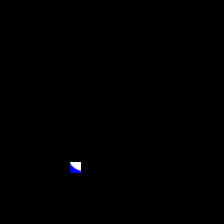

activation:tensor(36.2500, dtype=torch.float64)
football_helmet_6297.JPEG


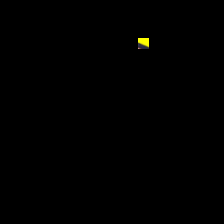

In [15]:
nodeid = 44
frame = True
num_examples = 100

layer_num,unit,layer_full_name = nodeid_2_perlayerid(nodeid,params)
layer = 'conv'+str(layer_num)

select_data_acts = max_activations['layer']['conv'+str(layer_num)][0][:,unit]
select_data_positions = max_activations['layer']['conv'+str(layer_num)][1][:,unit,:]

top_activations = torch.topk(torch.DoubleTensor(select_data_acts),200)

print('UNIT: ' + str(unit))
examples = list(range(num_examples))

print(nodeid)
deepviz_path = './prepped_models/'+prepped_model_folder+'/visualizations/images/neuron/'+str(nodeid)+'.jpg'
deep_image = Image.open(deepviz_path)
display(deep_image)
deep_tensor = preprocess_image(deepviz_path,params)
deep_tensor = deep_tensor.to(params['device'])
activations = {}
output = model(deep_tensor)
print(torch.max(activations[layer][:,unit,:,:]))

for example in range(num_examples):
    print('activation:'+str(top_activations.values[example]))
    image_path = max_activations['image_folder']+'/'+image_names[int(top_activations.indices[example])]
    print(image_names[int(top_activations.indices[example])])
    position = (int(select_data_positions[top_activations.indices[example],0]),int(select_data_positions[top_activations.indices[example],1]))
    display_image_patch_for_activation(image_path,layer,position,params,frame=frame)



In [38]:
name_dict

{'conv0': 'features_0',
 'conv1': 'features_3',
 'conv2': 'features_6',
 'conv3': 'features_8',
 'conv4': 'features_10'}

In [32]:

#return list of names for conv modules based on their nested module names '_' seperated
def get_conv_full_names(model,mod_names = [],mod_full_names = []):
    #gen names based on nested modules
    for name, module in model._modules.items():
        if len(list(module.children())) > 0:
            mod_names.append(str(name))
            # recurse
            mod_full_names = get_conv_full_names(module,mod_names = mod_names, mod_full_names = mod_full_names)
            mod_names.pop()

        if isinstance(module, torch.nn.modules.conv.Conv2d):    # found a 2d conv module
            mod_full_names.append('_'.join(mod_names+[name]))
            #new_module = dissected_Conv2d(module, name='_'.join(mod_names+[name]), store_activations=store_activations,store_ranks=store_ranks,clear_ranks=clear_ranks,cuda=cuda,device=device) 
            #model._modules[name] = new_module
    return mod_full_names     

    
#return list of names for conv modules based on their simple order, first conv is 'conv1', then 'conv2' etc. 
def get_conv_simple_names(model):
    names = []
    count = 0
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d):
            names.append('conv'+str(count))
            count+=1
    return names
 
# returns a dict that maps simple names to full names
def gen_conv_name_dict(model):
    simple_names = get_conv_simple_names(model)
    full_names = get_conv_full_names(model)
    return dict(zip(simple_names, full_names))


name_dict = gen_conv_name_dict(model)
print(name_dict)


{'conv0': 'features_0', 'conv1': 'features_3', 'conv2': 'features_6', 'conv3': 'features_8', 'conv4': 'features_10'}


## get similarities of max act images within a layer

UNIT: 11
torch.Size([300, 256])
maximum similarity: 0.989666
activation of unit:tensor(21.4688, dtype=torch.float64)
mink_28355.JPEG


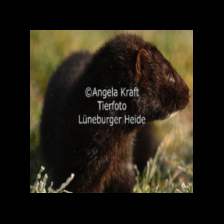

activation of unit:tensor(21.4062, dtype=torch.float64)
mink_15773.JPEG


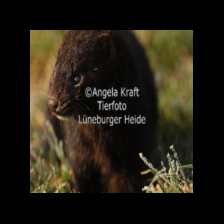

minimum similarity: 0.59667885
activation of unit:tensor(20.6094, dtype=torch.float64)
running_shoe_890.JPEG


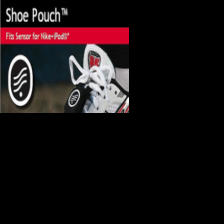

activation of unit:tensor(20.1250, dtype=torch.float64)
electric_fan_23464.JPEG


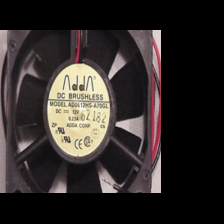

In [74]:
from torch.nn import functional as F


nodeid = 907
frame = True
num_examples = 300

layer_num,unit,layer_full_name = nodeid_2_perlayerid(nodeid,params)
layer = 'conv'+str(layer_num)

select_data_acts = max_activations['layer']['conv'+str(layer_num)][0][:,unit]
select_data_positions = max_activations['layer']['conv'+str(layer_num)][1][:,unit,:]

top_activations = torch.topk(torch.DoubleTensor(select_data_acts),num_examples)

print('UNIT: ' + str(unit))
examples = list(range(num_examples))



activations = {}
image_batch = None
for example in examples: 
    image_path = max_activations['image_folder']+'/'+image_names[int(top_activations.indices[example])]
    processed_image = preprocess_image(image_path,params)
    if image_batch is None:
        image_batch = processed_image
    else:
        image_batch = torch.cat((image_batch,processed_image))
        
output = model(image_batch)

patch_acts = []
for example in examples:
    position = (int(select_data_positions[top_activations.indices[example],0]),int(select_data_positions[top_activations.indices[example],1]))
    patch_acts.append(activations[layer][example,:,position[0],position[1]])
patch_acts = torch.stack(patch_acts)       
print(patch_acts.shape)

mask = torch.zeros(patch_acts.shape[1])
mask = mask==0
mask[unit] = False
patch_acts = patch_acts[:,mask]
sim_matrix = F.cosine_similarity(patch_acts[None, :, :], patch_acts[:, None, :], dim=-1)
sim_matrix = torch.triu(sim_matrix, diagonal=1)
sim_matrix[sim_matrix==0] = float('nan')

#display minimumly similar images
min_indices = unravel_index(torch.tensor(np.nanargmin(sim_matrix)),sim_matrix.shape).to('cpu')
max_indices = unravel_index(torch.tensor(np.nanargmax(sim_matrix)),sim_matrix.shape).to('cpu')
min_sim = np.nanmin(sim_matrix)
max_sim = np.nanmax(sim_matrix)


print('maximum similarity: '+str(max_sim))
for i in range(2):
    image_path = max_activations['image_folder']+'/'+image_names[int(top_activations.indices[max_indices[i]])]
    position = position = (int(select_data_positions[top_activations.indices[max_indices[i]],0]),int(select_data_positions[top_activations.indices[max_indices[i]],1]))
    print('activation of unit:' +str(top_activations.values[max_indices[i]]))
    print(image_names[int(top_activations.indices[max_indices[i]])])
    display_image_patch_for_activation(image_path,layer,position,params)
    

print('minimum similarity: '+str(min_sim))
for i in range(2):
    image_path = max_activations['image_folder']+'/'+image_names[int(top_activations.indices[min_indices[i]])]
    position = position = (int(select_data_positions[top_activations.indices[min_indices[i]],0]),int(select_data_positions[top_activations.indices[min_indices[i]],1]))
    print('activation of unit:' +str(top_activations.values[min_indices[i]]))
    print(image_names[int(top_activations.indices[min_indices[i]])])
    display_image_patch_for_activation(image_path,layer,position,params)
    


In [69]:
label_f = open('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/labels.txt')
labels = [x.strip() for x in label_f.readlines()]

weird_labels = os.listdir('/mnt/data/datasets/imagenet/train')
weird_labels.sort()

label_dict = dict(zip(weird_labels, labels))

output_dir =  '/mnt/data/datasets/imagenet/all_images'

imagenet_folder = '/mnt/data/datasets/imagenet/'

In [15]:
def get_key(val,dic):
    for key, value in dic.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [16]:
get_key('partridge',label_dict)

'n01807496'

## Clustering activations

In [33]:
from sklearn.manifold import TSNE
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}



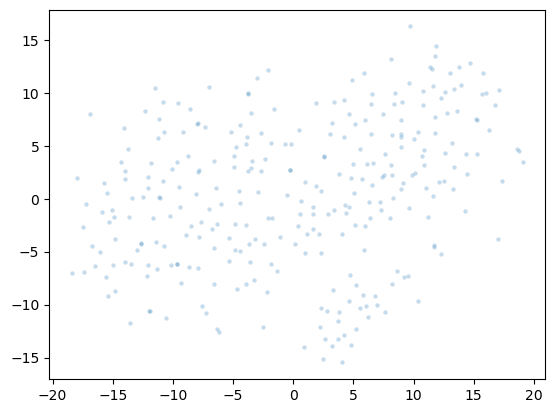

In [75]:
projection = TSNE().fit_transform(patch_acts)
plt.scatter(*projection.T, **plot_kwds)
plt.show()

In [76]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(patch_acts)

In [77]:
clusterer.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

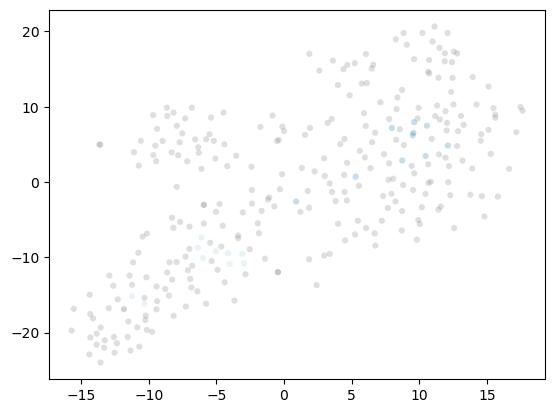

In [66]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.show()

In [79]:
patch_acts.shape

torch.Size([300, 255])

## Save cluster data for all neurons

In [17]:
frame = False
num_examples = 300
image_patch_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/visualizations/images/max_image_patches/'
patch_acts_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/maxpatch_layer_activations/'
clusters_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/maxpatch_layer_clusters/'
for nodeid in range(1152):

    if not os.path.exists(image_patch_folder+str(nodeid)):
        os.mkdir(image_patch_folder+str(nodeid))

    layer_num,unit,layer_full_name = nodeid_2_perlayerid(nodeid,params)
    layer = 'conv'+str(layer_num)

    select_data_acts = max_activations['layer']['conv'+str(layer_num)][0][:,unit]
    select_data_positions = max_activations['layer']['conv'+str(layer_num)][1][:,unit,:]

    top_activations = torch.topk(torch.DoubleTensor(select_data_acts),num_examples)

    print('UNIT: ' + str(unit))
    examples = list(range(num_examples))

    activations = {}
    image_batch = None
    
    for example in range(num_examples):
        #save image
        #print('activation:'+str(top_activations.values[example]))
        image_path = max_activations['image_folder']+'/'+image_names[int(top_activations.indices[example])]
        position = (int(select_data_positions[top_activations.indices[example],0]),int(select_data_positions[top_activations.indices[example],1]))
        save_path = image_patch_folder+'/'+str(nodeid)+'/'+str(float(top_activations.values[example]))+'_'+image_names[int(top_activations.indices[example])]
        display_image_patch_for_activation(image_path,layer,position,params,frame=frame,save = save_path)
        
        #add to batch to run through model
        processed_image = preprocess_image(image_path,params)
        if image_batch is None:
            image_batch = processed_image
        else:
            image_batch = torch.cat((image_batch,processed_image))

    output = model(image_batch)

    patch_acts = []
    for example in examples:
        position = (int(select_data_positions[top_activations.indices[example],0]),int(select_data_positions[top_activations.indices[example],1]))
        patch_acts.append(activations[layer][example,:,position[0],position[1]])
    patch_acts = torch.stack(patch_acts)       
    pickle.dump(patch_acts,open(patch_acts_folder+str(nodeid)+'_top'+str(num_examples)+'.pkl','wb'))
    
    mask = torch.zeros(patch_acts.shape[1])
    mask = mask==0
    mask[unit] = False
    patch_acts = patch_acts[:,mask]
    sim_matrix = F.cosine_similarity(patch_acts[None, :, :], patch_acts[:, None, :], dim=-1)
    sim_matrix = torch.triu(sim_matrix, diagonal=1)
    sim_matrix[sim_matrix==0] = float('nan')
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(patch_acts)
    pickle.dump(clusterer,open(clusters_folder+str(nodeid)+'_top'+str(num_examples)+'.pkl','wb'))
    


UNIT: 0
UNIT: 1
UNIT: 2
UNIT: 3
UNIT: 4
UNIT: 5
UNIT: 6
UNIT: 7
UNIT: 8
UNIT: 9
UNIT: 10
UNIT: 11
UNIT: 12
UNIT: 13
UNIT: 14
UNIT: 15
UNIT: 16
UNIT: 17
UNIT: 18
UNIT: 19
UNIT: 20
UNIT: 21
UNIT: 22
UNIT: 23
UNIT: 24
UNIT: 25
UNIT: 26
UNIT: 27
UNIT: 28
UNIT: 29
UNIT: 30
UNIT: 31
UNIT: 32
UNIT: 33
UNIT: 34
UNIT: 35
UNIT: 36
UNIT: 37
UNIT: 38
UNIT: 39
UNIT: 40
UNIT: 41
UNIT: 42
UNIT: 43
UNIT: 44
UNIT: 45
UNIT: 46
UNIT: 47
UNIT: 48
UNIT: 49
UNIT: 50
UNIT: 51
UNIT: 52
UNIT: 53
UNIT: 54
UNIT: 55
UNIT: 56
UNIT: 57
UNIT: 58
UNIT: 59
UNIT: 60
UNIT: 61
UNIT: 62
UNIT: 63
UNIT: 0
UNIT: 1
UNIT: 2
UNIT: 3
UNIT: 4
UNIT: 5
UNIT: 6
UNIT: 7
UNIT: 8
UNIT: 9
UNIT: 10
UNIT: 11
UNIT: 12
UNIT: 13
UNIT: 14
UNIT: 15
UNIT: 16
UNIT: 17
UNIT: 18
UNIT: 19
UNIT: 20
UNIT: 21
UNIT: 22
UNIT: 23
UNIT: 24
UNIT: 25
UNIT: 26
UNIT: 27
UNIT: 28
UNIT: 29
UNIT: 30
UNIT: 31
UNIT: 32
UNIT: 33
UNIT: 34
UNIT: 35
UNIT: 36
UNIT: 37
UNIT: 38
UNIT: 39
UNIT: 40
UNIT: 41
UNIT: 42
UNIT: 43
UNIT: 44
UNIT: 45
UNIT: 46
UNIT: 47
UNIT: 48
UNI

UNIT: 220
UNIT: 221
UNIT: 222
UNIT: 223
UNIT: 224
UNIT: 225
UNIT: 226
UNIT: 227
UNIT: 228
UNIT: 229
UNIT: 230
UNIT: 231
UNIT: 232
UNIT: 233
UNIT: 234
UNIT: 235
UNIT: 236
UNIT: 237
UNIT: 238
UNIT: 239
UNIT: 240
UNIT: 241
UNIT: 242
UNIT: 243
UNIT: 244
UNIT: 245
UNIT: 246
UNIT: 247
UNIT: 248
UNIT: 249
UNIT: 250
UNIT: 251
UNIT: 252
UNIT: 253
UNIT: 254
UNIT: 255
UNIT: 0
UNIT: 1
UNIT: 2
UNIT: 3
UNIT: 4
UNIT: 5
UNIT: 6
UNIT: 7
UNIT: 8
UNIT: 9
UNIT: 10
UNIT: 11
UNIT: 12
UNIT: 13
UNIT: 14
UNIT: 15
UNIT: 16
UNIT: 17
UNIT: 18
UNIT: 19
UNIT: 20
UNIT: 21
UNIT: 22
UNIT: 23
UNIT: 24
UNIT: 25
UNIT: 26
UNIT: 27
UNIT: 28
UNIT: 29
UNIT: 30
UNIT: 31
UNIT: 32
UNIT: 33
UNIT: 34
UNIT: 35
UNIT: 36
UNIT: 37
UNIT: 38
UNIT: 39
UNIT: 40
UNIT: 41
UNIT: 42
UNIT: 43
UNIT: 44
UNIT: 45
UNIT: 46
UNIT: 47
UNIT: 48
UNIT: 49
UNIT: 50
UNIT: 51
UNIT: 52
UNIT: 53
UNIT: 54
UNIT: 55
UNIT: 56
UNIT: 57
UNIT: 58
UNIT: 59
UNIT: 60
UNIT: 61
UNIT: 62
UNIT: 63
UNIT: 64
UNIT: 65
UNIT: 66
UNIT: 67
UNIT: 68
UNIT: 69
UNIT: 70
UNIT: 71
UN

In [27]:
clusters[1151].labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,
       -1,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,
        0,  0, -1,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  0,
        0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  1,  0,  1,  0,  0,
        0,  0,  0,  1,  0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,
        0,  1,  0,  0,  0

In [28]:
color_palette

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

## Show images and clusters

In [34]:
clusters = []

for i in range(1152):
    cluster = pickle.load(open('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/maxpatch_layer_clusters/'+str(i)+'_top300.pkl','rb'))
    clusters.append(cluster)

In [ ]:
for i,clusterer in enumerate(clusters):
    if 0 in clusterer.labels_ and i==905:
        print(i)
        patch_acts = pickle.load(open('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/maxpatch_layer_activations/'+str(i)+'_top300.pkl','rb'))
        projection = TSNE().fit_transform(patch_acts)
        color_palette = sns.color_palette()
        cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
        plt.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.7)
        plt.show()
        
        layer_num,unit,layer_full_name = nodeid_2_perlayerid(i,params)
        layer = 'conv'+str(layer_num)

        select_data_acts = max_activations['layer']['conv'+str(layer_num)][0][:,unit]
        select_data_positions = max_activations['layer']['conv'+str(layer_num)][1][:,unit,:]

        top_activations = torch.topk(torch.DoubleTensor(select_data_acts),300)
        
        
        cluster_indices = {}
        for j in range(300):
            clust_i = int(clusterer.labels_[j])
            if clust_i >= 0:
                if clust_i not in cluster_indices.keys():
                    cluster_indices[clust_i] = [j]
                else:
                    cluster_indices[clust_i].append(j)
                    
        for clust in cluster_indices:
            print('cluster %s images: %s'%(str(clust),str(len(cluster_indices[clust]))))
            count = 0
            for ind in cluster_indices[clust]:
                if count < 10:
                    image_path = max_activations['image_folder']+'/'+image_names[int(top_activations.indices[ind])]
                    position = (int(select_data_positions[top_activations.indices[ind],0]),int(select_data_positions[top_activations.indices[ind],1]))
                    print(select_data_acts[top_activations.indices[ind]])
                    display_image_patch_for_activation(image_path,layer,position,params,frame=False)
                    count += 1

            
        

## subgraphs for clusters

In [35]:
clusterable_nodes = []
for i,clusterer in enumerate(clusters):
    if 0 in clusterer.labels_:
        clusterable_nodes.append(i)
clusterable_nodes.reverse()       
print(clusterable_nodes)
print(len(clusterable_nodes))

[1151, 1147, 1141, 1131, 1122, 1099, 1091, 1086, 1079, 1073, 1070, 1063, 1060, 1057, 1056, 1050, 1044, 1043, 1039, 1034, 1033, 1029, 1017, 1014, 1013, 1010, 1004, 996, 985, 984, 970, 968, 960, 949, 942, 940, 930, 923, 922, 916, 914, 911, 905, 899, 896, 886, 885, 884, 883, 876, 875, 874, 873, 871, 868, 863, 862, 851, 847, 846, 840, 838, 827, 811, 805, 804, 803, 796, 794, 786, 780, 774, 768, 766, 759, 756, 755, 748, 745, 742, 740, 736, 734, 729, 722, 721, 718, 708, 689, 686, 684, 679, 672, 651, 650, 647, 646, 643, 640, 615, 610, 592, 589, 586, 582, 569, 544, 504, 499, 498, 477, 472, 460, 438, 427, 409, 403, 401, 396, 392, 383, 375, 352, 351, 343, 339, 332, 327, 301, 288, 287, 285, 284, 247, 245, 244, 237, 235, 220, 216, 209, 207, 202, 191, 187, 184, 179, 175, 168, 156, 149, 147, 142, 141, 136, 131, 127, 125, 123, 113, 111, 110, 107, 101, 98, 97, 95, 82, 72, 68, 65, 62, 59, 58, 56, 53, 52, 51, 47, 46, 43, 40, 39, 36, 35, 33, 30, 28, 26, 24, 23, 20, 19, 18, 17, 15, 13, 5, 3, 1, 0]
201


In [ ]:


#params
edge_threshold = .9
node_threshold = .9
max_images_per_cluster = 50
rank_type = 'actxgrad'
output_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/subneuron_max_activation_clusters/'
cluster_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/maxpatch_layer_clusters/'

batch_size = params['batch_size']

#load dissected model
model_dis = dissect_model(deepcopy(prep_model_params.model),store_ranks=True,clear_ranks=True,cuda=params['cuda'],device=params['device']) #version of model with accessible preadd activations in Conv2d modules 
if params['cuda']:
    model_dis.cuda()
model_dis = model_dis.eval()    
model_dis.to(params['device'])

model_dis = clear_ranks_across_model(model_dis)
model_dis = set_across_model(model_dis,'rank_field','max')
model_dis = set_across_model(model_dis,'clear_ranks',False)



#run through each clusterable node:
for nodeid in clusterable_nodes:
    start = time.time()
    print(nodeid)
    model_dis = clear_ranks_across_model(model_dis)
    model_dis = set_across_model(model_dis,'rank_field','max')
    model_dis = set_across_model(model_dis,'clear_ranks',False)
    

    #Get max activation data
    layer_num,layerwise_id,layer_full_name = nodeid_2_perlayerid(nodeid,params)
    layer = 'conv'+str(layer_num)

    select_data_acts = max_activations['layer']['conv'+str(layer_num)][0][:,layerwise_id]
    select_data_positions = max_activations['layer']['conv'+str(layer_num)][1][:,layerwise_id,:]
    top_activations = torch.topk(torch.DoubleTensor(select_data_acts),300)

    #set target node in model
    model_dis = set_model_target_node(model_dis,layer_num,layerwise_id)

    #get clusters
    clusterer = pickle.load(open(cluster_folder+str(nodeid)+'_top300.pkl','rb'))      
    cluster_indices = {}
    for j in range(300):
        clust_i = int(clusterer.labels_[j])
        if clust_i >= 0:
            if clust_i not in cluster_indices.keys():
                cluster_indices[clust_i] = [j]
            else:
                cluster_indices[clust_i].append(j)




    #get image batches
    cluster_image_names = {}
    for clust in cluster_indices:
        cluster_image_names['cluster'+str(clust)] = []
        print('cluster %s images: %s'%(str(clust),str(len(cluster_indices[clust]))))
        num_images = 0
        for ind in cluster_indices[clust]:
            if num_images < max_images_per_cluster:
                cluster_image_names['cluster'+str(clust)].append(image_names[int(top_activations.indices[ind])])
                num_images += 1


    for cluster in cluster_image_names: 
        print(cluster)
        model_dis = clear_ranks_across_model(model_dis)
        #run image batches through model
        image_batch = None
        for name in cluster_image_names[cluster]: 
            image_path = max_activations['image_folder']+'/'+name
            processed_image = preprocess_image(image_path,params)
            if image_batch is None:
                image_batch = processed_image
            else:
                image_batch = torch.cat((image_batch,processed_image))
            if int(image_batch.size(0)) == batch_size:
                #import pdb;pdb.set_trace()
                model_dis.zero_grad()
                
                try:
                    output = model_dis(image_batch)
                except TargetReached:
                    #print('target node %s reached, halted forward pass'%str(nodeid)) 
                    pass
                    
                image_batch = None
        if image_batch is not None:   #run remainder through model
            model_dis.zero_grad()
            try:
                output = model_dis(image_batch)
            except TargetReached:
                #print('target node %s reached, halted forward pass'%str(nodeid)) 
                pass
                

        layer_ranks = get_ranks_from_dissected_Conv2d_modules(model_dis)
        model_dis = clear_ranks_across_model(model_dis)

        #make DFs
        target_nodes_df,target_edges_df = rank_dict_2_df(layer_ranks)
        target_edges_df = minmax_normalize_ranks_df(target_edges_df,params)
        target_nodes_df = minmax_normalize_ranks_df(target_nodes_df,params)

        #threshold df to make subgraph
        nodes_thresholded_df,edges_thresholded_df = hierarchical_accum_threshold(node_threshold,edge_threshold,rank_type,target_edges_df,target_nodes_df,ascending=False)

        #save subgraph model
        sub_model = extract_subgraph(model,nodes_thresholded_df,edges_thresholded_df,params)
        save_object = {'model':sub_model,
                       'node_df':nodes_thresholded_df,
                       'edge_df':edges_thresholded_df,
                       'gen_params':{'node_thresh':node_threshold,
                                     'edge_thresh':edge_threshold,
                                     'input':cluster_image_names[cluster],
                                     'output':str(nodeid)}}
        torch.save(save_object,output_folder+'/'+str(nodeid)+'_'+cluster+'.pt')
    print(time.time() - start)
        


## subgraphs split across cluster

In [20]:

#params
edge_threshold = .9
node_threshold = .9
max_images_per_cluster = 50
rank_type = 'actxgrad'
output_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/subneuron_max_activation_clusters/'
cluster_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/maxpatch_layer_clusters/'

batch_size = params['batch_size']

#load dissected model
model_dis = dissect_model(deepcopy(prep_model_params.model),store_ranks=True,clear_ranks=True,cuda=params['cuda'],device=params['device']) #version of model with accessible preadd activations in Conv2d modules 
if params['cuda']:
    model_dis.cuda()
model_dis = model_dis.eval()    
model_dis.to(params['device'])

model_dis = clear_ranks_across_model(model_dis)
model_dis = set_across_model(model_dis,'rank_field','max')
model_dis = set_across_model(model_dis,'clear_ranks',False)



#run through each clusterable node:
for nodeid in clusterable_nodes:
    if nodeid not in min_nodes:
        continue
    
    start = time.time()
    print(nodeid)
    model_dis = clear_ranks_across_model(model_dis)
    model_dis = set_across_model(model_dis,'rank_field','max')
    model_dis = set_across_model(model_dis,'clear_ranks',False)
    

    #Get max activation data
    layer_num,layerwise_id,layer_full_name = nodeid_2_perlayerid(nodeid,params)
    layer = 'conv'+str(layer_num)

    select_data_acts = max_activations['layer']['conv'+str(layer_num)][0][:,layerwise_id]
    select_data_positions = max_activations['layer']['conv'+str(layer_num)][1][:,layerwise_id,:]
    top_activations = torch.topk(torch.DoubleTensor(select_data_acts),300)

    #set target node in model
    model_dis = set_model_target_node(model_dis,layer_num,layerwise_id)

    #get clusters
    clusterer = pickle.load(open(cluster_folder+str(nodeid)+'_top300.pkl','rb'))      
    cluster_indices = {}
    for j in range(300):
        clust_i = int(clusterer.labels_[j])
        if clust_i >= 0:
            if clust_i not in cluster_indices.keys():
                cluster_indices[clust_i] = [j]
            else:
                cluster_indices[clust_i].append(j)




    #get image batches
    cluster_image_names = {}
    for clust in cluster_indices:
        cluster_image_names['cluster'+str(clust)] = []
        print('cluster %s images: %s'%(str(clust),str(len(cluster_indices[clust]))))
        num_images = 0
        for ind in cluster_indices[clust]:
            if num_images < max_images_per_cluster:
                cluster_image_names['cluster'+str(clust)].append(image_names[int(top_activations.indices[ind])])
                num_images += 1


                
    non_cluster_image_names = {0:[],1:[]}
    for i in range(0,max_images_per_cluster,2):
        try:
            non_cluster_image_names[0].append(cluster_image_names['cluster'+str(0)][i])
            non_cluster_image_names[0].append(cluster_image_names['cluster'+str(1)][i])
            non_cluster_image_names[1].append(cluster_image_names['cluster'+str(0)][i+1])
            non_cluster_image_names[1].append(cluster_image_names['cluster'+str(1)][i+1])
        except:
            break
    
    print(non_cluster_image_names)
    
    
    for cluster in non_cluster_image_names: 
        print(cluster)
        model_dis = clear_ranks_across_model(model_dis)
        #run image batches through model
        image_batch = None
        for name in non_cluster_image_names[cluster]: 
            image_path = max_activations['image_folder']+'/'+name
            processed_image = preprocess_image(image_path,params)
            if image_batch is None:
                image_batch = processed_image
            else:
                image_batch = torch.cat((image_batch,processed_image))
            if int(image_batch.size(0)) == batch_size:
                #import pdb;pdb.set_trace()
                model_dis.zero_grad()
                
                try:
                    output = model_dis(image_batch)
                except TargetReached:
                    #print('target node %s reached, halted forward pass'%str(nodeid)) 
                    pass
                    
                image_batch = None
        if image_batch is not None:   #run remainder through model
            model_dis.zero_grad()
            try:
                output = model_dis(image_batch)
            except TargetReached:
                #print('target node %s reached, halted forward pass'%str(nodeid)) 
                pass
                

        layer_ranks = get_ranks_from_dissected_Conv2d_modules(model_dis)
        model_dis = clear_ranks_across_model(model_dis)

        #make DFs
        target_nodes_df,target_edges_df = rank_dict_2_df(layer_ranks)
        target_edges_df = minmax_normalize_ranks_df(target_edges_df,params)
        target_nodes_df = minmax_normalize_ranks_df(target_nodes_df,params)

        #threshold df to make subgraph
        nodes_thresholded_df,edges_thresholded_df = hierarchical_accum_threshold(node_threshold,edge_threshold,rank_type,target_edges_df,target_nodes_df,ascending=False)

        #save subgraph model
        sub_model = extract_subgraph(model,nodes_thresholded_df,edges_thresholded_df,params)
        save_object = {'model':sub_model,
                       'node_df':nodes_thresholded_df,
                       'edge_df':edges_thresholded_df,
                       'gen_params':{'node_thresh':node_threshold,
                                     'edge_thresh':edge_threshold,
                                     'input':non_cluster_image_names[cluster],
                                     'output':str(nodeid)}}
        torch.save(save_object,output_folder+'/'+str(nodeid)+'_'+'splitcluster'+str(cluster)+'.pt')
    print(time.time() - start)
        

1151
cluster 0 images: 230
cluster 1 images: 64
{0: ['grille_20844.JPEG', 'Yorkshire_terrier_9389.JPEG', 'grille_12087.JPEG', 'silky_terrier_1225.JPEG', 'sock_10352.JPEG', 'Yorkshire_terrier_15399.JPEG', 'microphone_3841.JPEG', 'Yorkshire_terrier_15961.JPEG', 'zebra_3267.JPEG', 'Yorkshire_terrier_00008324.JPEG', 'accordion_3607.JPEG', 'Yorkshire_terrier_00045818.JPEG', 'zebra_3018.JPEG', 'Dandie_Dinmont_6953.JPEG', 'accordion_1688.JPEG', 'otterhound_983.JPEG', 'folding_chair_2936.JPEG', 'Maltese_dog_14028.JPEG', 'loudspeaker_68026.JPEG', 'lesser_panda_544.JPEG', 'screw_3927.JPEG', 'Lhasa_1618.JPEG', 'stupa_00045423.JPEG', 'Yorkshire_terrier_8243.JPEG', 'accordion_20786.JPEG', 'miniature_schnauzer_4036.JPEG', 'grille_3978.JPEG', 'Maltese_dog_17993.JPEG', 'drumstick_2527.JPEG', 'beaver_15670.JPEG', 'folding_chair_3838.JPEG', 'Yorkshire_terrier_5868.JPEG', 'iron_38496.JPEG', 'Lhasa_00039807.JPEG', 'electric_fan_11938.JPEG', 'silky_terrier_1780.JPEG', 'typewriter_keyboard_4895.JPEG', 'York

[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
31.546067237854004
1004
cluster 0 images: 249
cluster 1 images: 51
{0: ['umbrella_9399.JPEG', 'Great_Pyrenees_7292.JPEG', 'umbrella_16912.JPEG', 'boxer_1621.JPEG', 'pinwheel_14378.JPEG', 'collie_28270.JPEG', 'yurt_6579.JPEG', 'Irish_water_spaniel_3998.JPEG', 'lionfish_859.JPEG', 'German_shepherd_1503.JPEG', 'dome_3990.JPEG', 'beagle_10837.JPEG', 'lampshade_26696.JPEG', 'Blenheim_spaniel_380.JPEG', 'maypole_150.JPEG', 'golden_retriever_5488.JPEG', 'wall_clock_4150.JPEG', 'English_foxhound_4511.JPEG', 'yurt_9161.JPEG', 'wire_haired_fox_terrier_3586.JPEG', 'pole_18790.JPEG', 'Walker_hound_8841.JPEG', 'coil_2986.JPEG', 'golden_retriever_6884.JPEG', 'monarch_40224.JPEG', 'Shetland_sheepdog_15820.JPEG', 'maypole_7904.JPEG', 'Afghan_hound_7282.JPEG', 'monarch_7438.JPEG', 'collie_18019.JPEG', 'sea_urchin_6093.JPEG', 'beagle_4369.JPEG', 'monarch_15902.JPEG', 'Blenheim_spaniel_4902

maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 3
1
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 3
20.172900915145874
679
cluster 0 images: 166
cluster 1 images: 23
{0: ['tree_frog_3255.JPEG', 'organ_1497.JPEG', 'tree_frog_726.JPEG', 'microphone_11443.JPEG', 'parachute_73606.JPEG', 'stage_20191.JPEG', 'joystick_15817.JPEG', 'thimble_10211.JPEG', 'modem_12806.JPEG', 'planetarium_00000872.JPEG', 'paddle_53586.JPEG', 'Leonbe

layer: 0
layer: 1
layer: 2
12.653624773025513
327
cluster 0 images: 11
cluster 1 images: 235
{0: ['planetarium_00008607.JPEG', 'jersey_00006774.JPEG', 'window_screen_10708.JPEG', 'maillot_2_164.JPEG', 'puck_7660.JPEG', 'stethoscope_4648.JPEG', 'racket_6441.JPEG', 'electric_fan_15385.JPEG', 'car_wheel_6736.JPEG', 'comic_book_17880.JPEG', 'planetarium_15298.JPEG', 'water_jug_9421.JPEG'], 1: ['loudspeaker_34752.JPEG', 'barrow_13232.JPEG', 'pencil_box_4627.JPEG', 'black_and_tan_coonhound_4862.JPEG', 'fire_screen_11292.JPEG', 'acoustic_guitar_8075.JPEG', 'grille_21719.JPEG', 'muzzle_23751.JPEG', 'strainer_31183.JPEG', 'jersey_5519.JPEG']}
0
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 3
maximum value 0 for ra

## Compare Subgraph clusters

In [37]:

root_dir = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/subneuron_max_activation_clusters/'



overlap_dict = {}
for nodeid in clusterable_nodes:
    #print(str(nodeid)+'\n')
    sub1_name = str(nodeid)+'_cluster0.pt'
    sub2_name = str(nodeid)+'_cluster1.pt'

    sub1 = torch.load(root_dir+'/'+sub1_name,map_location='cpu')
    sub2 = torch.load(root_dir+'/'+sub2_name,map_location='cpu')
    #print(len(sub1['edge_df']))
    #print(len(sub2['edge_df']))

    set_1 = set(sub1['edge_df'].edge_num)
    set_2 = set(sub2['edge_df'].edge_num)

    intersec = set_1.intersection(set_2)
    union = set_1.union(set_2)
    #print(len(intersec)/len(union))
    overlap_dict[nodeid] = [len(intersec)/len(union),len(sub1['edge_df']),len(sub2['edge_df'])]
    #print('\n')




In [38]:
max_overlap = .3

min_nodes = []
for nodeid in overlap_dict:
    if overlap_dict[nodeid][0] < max_overlap:
        min_nodes.append(nodeid)
    
print(len(min_nodes))
    

14


## compare split clusters

In [39]:

root_dir = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/subneuron_max_activation_clusters/'



split_overlap_dict = {}
for nodeid in min_nodes:
    #print(str(nodeid)+'\n')
    sub1_name = str(nodeid)+'_splitcluster0.pt'
    sub2_name = str(nodeid)+'_splitcluster1.pt'

    sub1 = torch.load(root_dir+'/'+sub1_name,map_location='cpu')
    sub2 = torch.load(root_dir+'/'+sub2_name,map_location='cpu')
    #print(len(sub1['edge_df']))
    #print(len(sub2['edge_df']))

    set_1 = set(sub1['edge_df'].edge_num)
    set_2 = set(sub2['edge_df'].edge_num)

    intersec = set_1.intersection(set_2)
    union = set_1.union(set_2)
    #print(len(intersec)/len(union))
    split_overlap_dict[nodeid] = [len(intersec)/len(union),len(sub1['edge_df']),len(sub2['edge_df'])]
    #print('\n')



In [40]:
split_overlap_dict

{1151: [0.77850601154564, 20751, 20224],
 1063: [0.7505815756823822, 22449, 22702],
 1057: [0.7895805670545966, 22996, 22828],
 1044: [0.6825005519169917, 22850, 22877],
 1004: [0.7460661493779531, 20104, 20176],
 949: [0.7465082842667397, 25640, 25379],
 905: [0.7160291993004334, 22217, 22918],
 868: [0.6578322290286286, 6555, 6706],
 721: [0.7172239009650063, 8788, 8829],
 679: [0.7468239564428312, 7568, 7832],
 615: [0.6244995996797438, 993, 1036],
 460: [0.6154696132596685, 1453, 1471],
 339: [0.6216216216216216, 1339, 1361],
 327: [0.6120276742948377, 1578, 1451]}

In [42]:
min_nodes_overlap_dict = {}

for i in overlap_dict:
    if i in min_nodes:
        min_nodes_overlap_dict[i] = overlap_dict[i]
        
min_nodes_overlap_dict

{1151: [0.1765408029284208, 14308, 15262],
 1063: [0.20434736952640975, 17753, 16654],
 1057: [0.2227025127394131, 18004, 16788],
 1044: [0.18854423813101498, 19780, 13441],
 1004: [0.2569865620168867, 14330, 17380],
 949: [0.296655385834934, 21899, 20630],
 905: [0.2045028142589118, 16508, 17518],
 868: [0.29943372240841326, 7025, 4219],
 721: [0.2201554449393066, 5238, 8734],
 679: [0.269804822043628, 7059, 6213],
 615: [0.24154209284028325, 961, 617],
 460: [0.2972195589645254, 1673, 1033],
 339: [0.2271991365353481, 933, 1341],
 327: [0.21866666666666668, 665, 1620]}

In [45]:
min_node_overlap_list = []
split_overlap_list = []
for i in split_overlap_dict:
    min_node_overlap_list.append(min_nodes_overlap_dict[i][0])
    split_overlap_list.append(split_overlap_dict[i][0])
    
print('clusters overlap')
print(np.mean(min_node_overlap_list))
print(np.std(min_node_overlap_list))
    
print('split clusters overlap')
print(np.mean(split_overlap_list))
print(np.std(split_overlap_list))


clusters overlap
0.23745008070244017
0.039299587034786906
split clusters overlap
0.7003764953169338
0.06128850001933125


## Subgraph cluster visualizations

In [55]:
def gen_vizualizations_for_subgraph(path_2_subgraph_dict, params,all_neurons=False): #takes full path to subgraph dict
    subgraph_dict = torch.load(path_2_subgraph_dict)
    model = subgraph_dict['model']
    _ = model.to(params['device']).eval()
    subgraph_name = '.'.join(path_2_subgraph_dict.split('/')[-1].split('.')[:-1])
    print(subgraph_name)
    viz_folder = '/'.join(path_2_subgraph_dict.split('/')[:-2])+'/visualizations/'+subgraph_name
    print(viz_folder)
    if not os.path.exists(viz_folder):
        os.mkdir(viz_folder)
        os.mkdir(viz_folder+'/channel')
        os.mkdir(viz_folder+'/neuron')
        with open(viz_folder+'/images.csv', 'a') as images_csv:
            images_csv.write('image_name,targetid,objective,parametrizer,optimizer,transforms,neuron\n')
        images_csv.close()
    layer = -1
    within_id = 0
    node_df = deepcopy(subgraph_dict['node_df'])
    node_df = node_df.sort_values(by=['node_num'])
    for row in node_df.itertuples():
        layer_name = 'conv_'+str(row.layer)
        if row.layer == layer:
            within_id+=1
        else:
            layer += 1
            within_id = 0
        if all_neurons:
            fetch_deepviz_img_for_subgraph(model,layer_name,within_id,row.node_num,viz_folder,params)
    if not all_neurons:
        fetch_deepviz_img_for_subgraph(model,layer_name,within_id,row.node_num,viz_folder,params)



root_dir = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/subneuron_max_activation_clusters/'


# for nodeid in clusterable_nodes:
#     print(str(nodeid)+'\n')
#     sub1_name = str(nodeid)+'_cluster0.pt'
#     sub2_name = str(nodeid)+'_cluster1.pt'
   
#     gen_vizualizations_for_subgraph(root_dir+'/'+sub1_name, params)
#     gen_vizualizations_for_subgraph(root_dir+'/'+sub2_name, params)



327


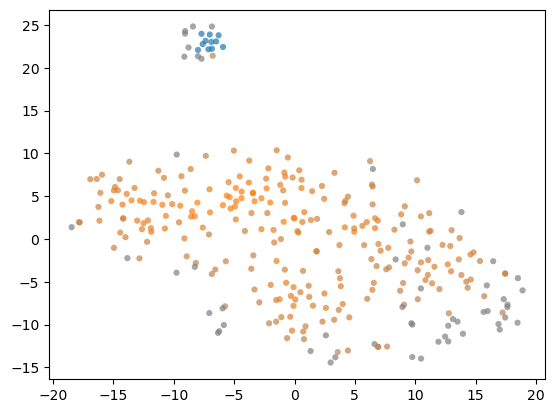

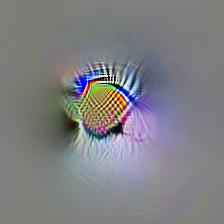

[0.21866666666666668, 665, 1620]


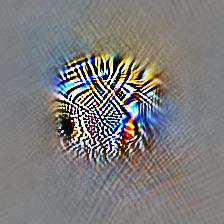

cluster 0 images: 11


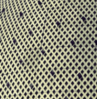

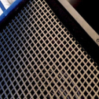

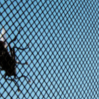

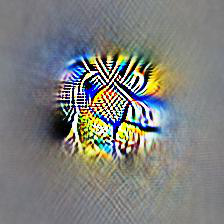

cluster 1 images: 235


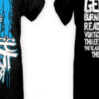

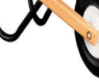

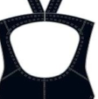




339


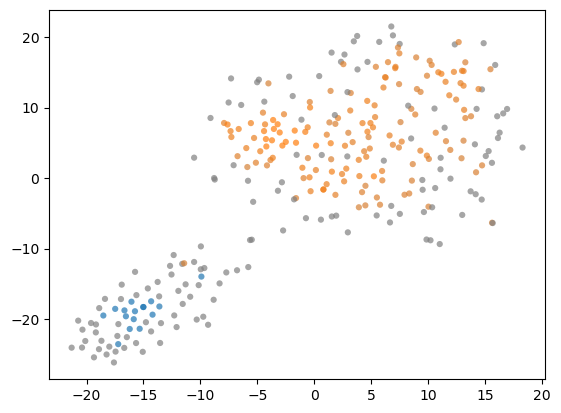

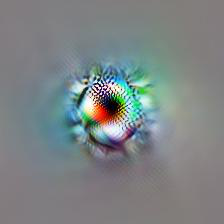

[0.2271991365353481, 933, 1341]


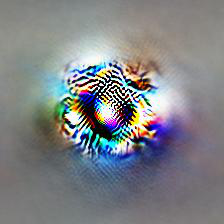

cluster 0 images: 16


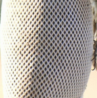

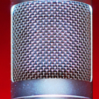

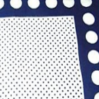

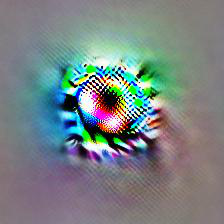

cluster 1 images: 143


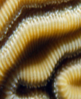

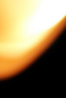

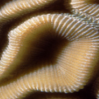




460


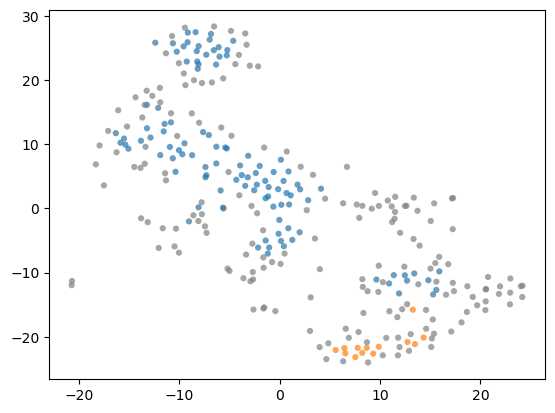

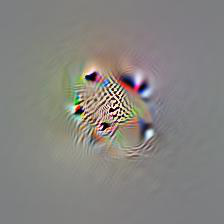

[0.2972195589645254, 1673, 1033]


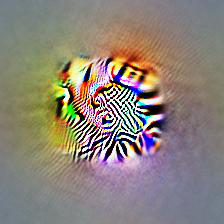

cluster 0 images: 107


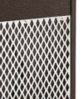

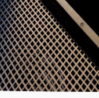

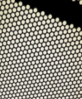

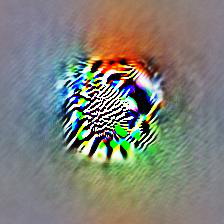

cluster 1 images: 13


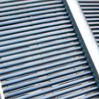

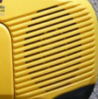

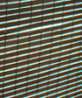




615


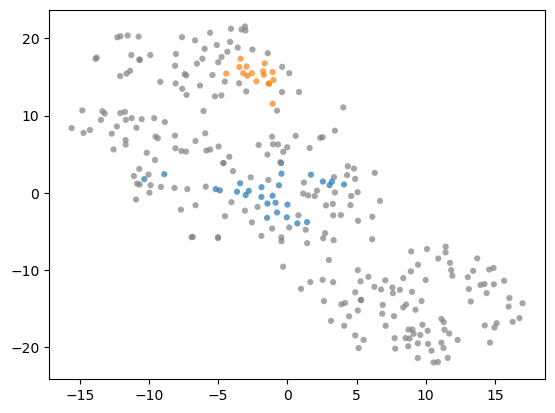

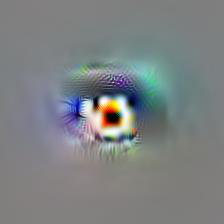

[0.24154209284028325, 961, 617]


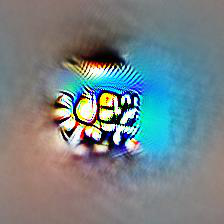

cluster 1 images: 16


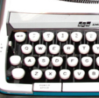

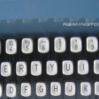

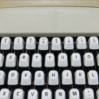

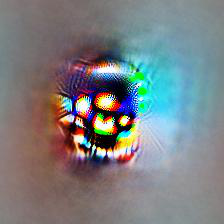

cluster 0 images: 27


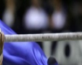

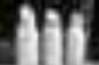

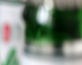




679


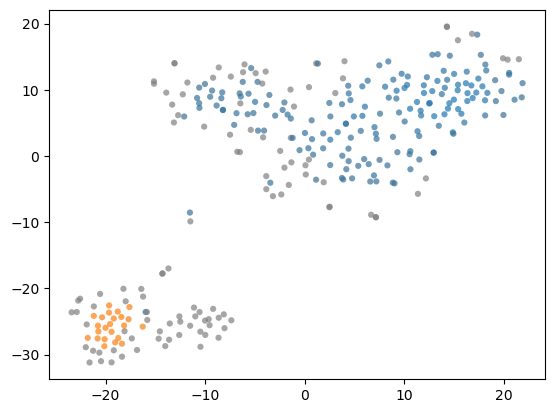

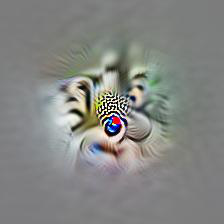

[0.269804822043628, 7059, 6213]


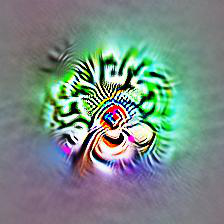

cluster 0 images: 166


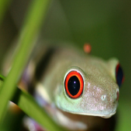

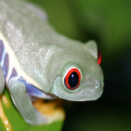

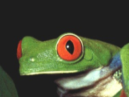

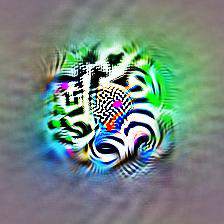

cluster 1 images: 23


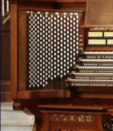

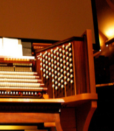

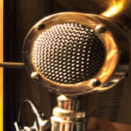




721


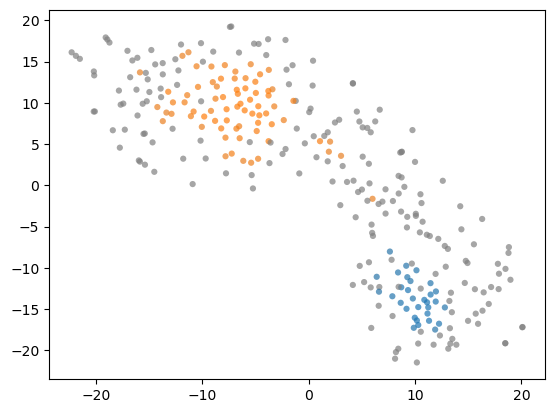

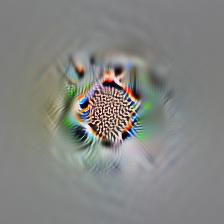

[0.2201554449393066, 5238, 8734]


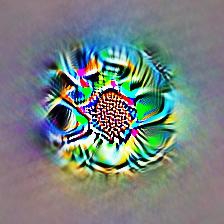

cluster 1 images: 72


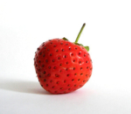

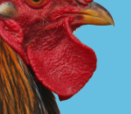

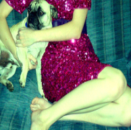

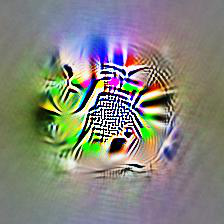

cluster 0 images: 31


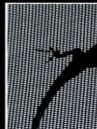

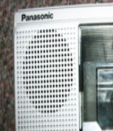

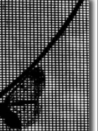




868


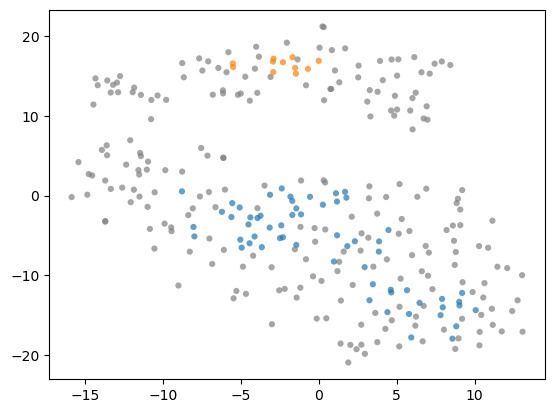

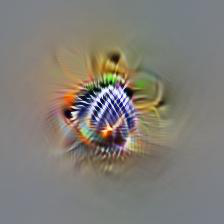

[0.29943372240841326, 7025, 4219]


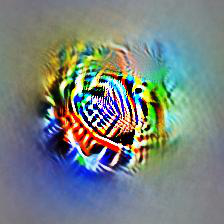

cluster 1 images: 11


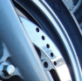

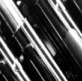

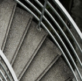

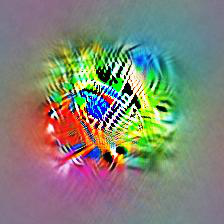

cluster 0 images: 60


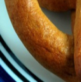

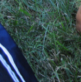

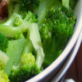




905


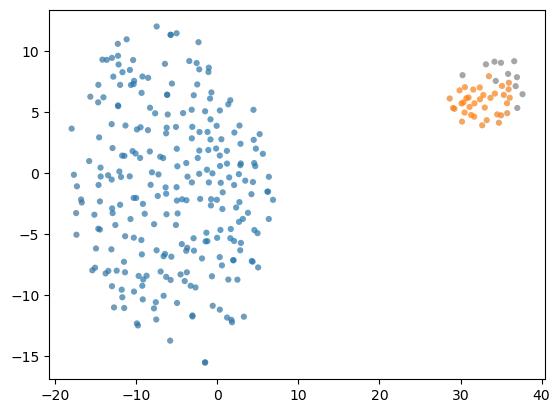

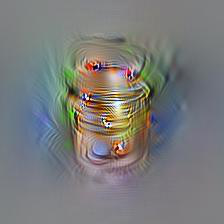

[0.2045028142589118, 16508, 17518]


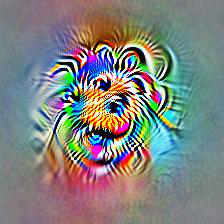

cluster 0 images: 254


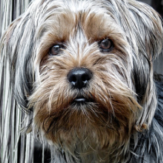

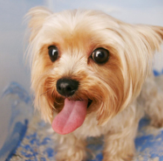

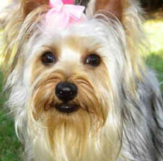

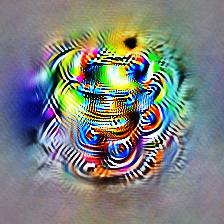

cluster 1 images: 35


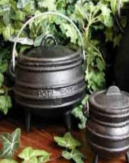

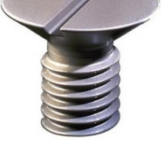

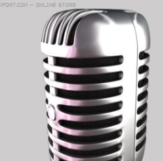




949


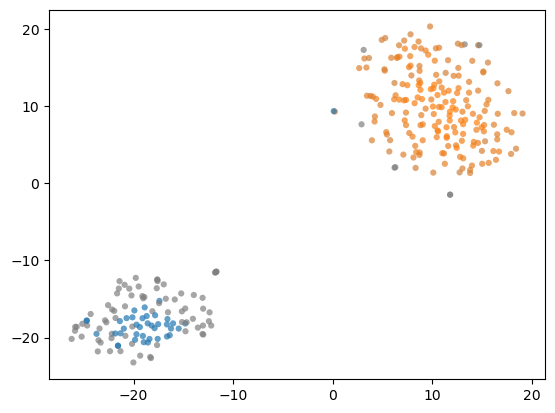

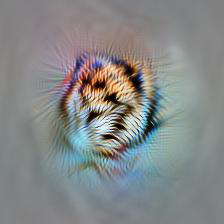

[0.296655385834934, 21899, 20630]


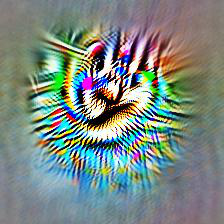

cluster 1 images: 179


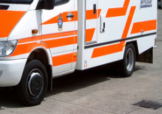

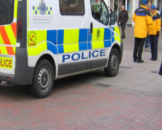

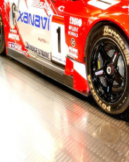

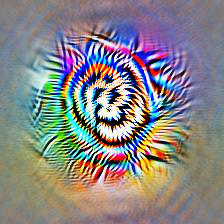

cluster 0 images: 39


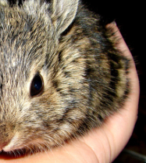

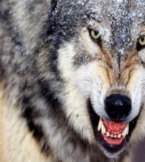

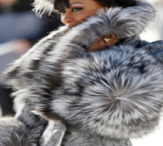




1004


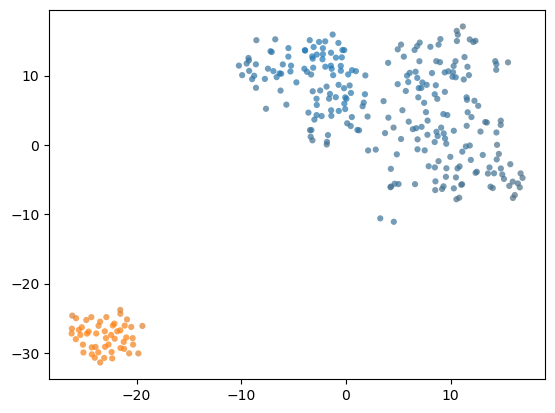

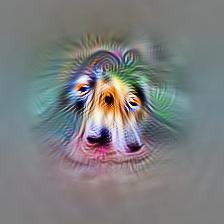

[0.2569865620168867, 14330, 17380]


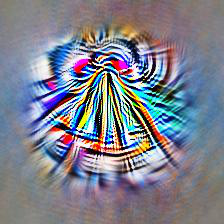

cluster 0 images: 249


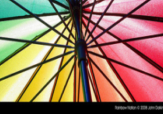

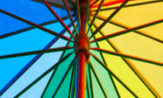

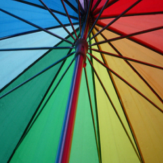

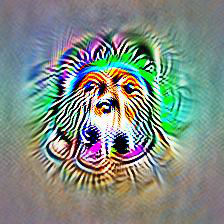

cluster 1 images: 51


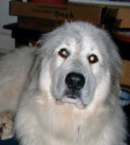

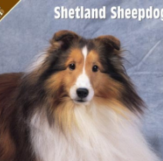

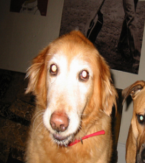




1044


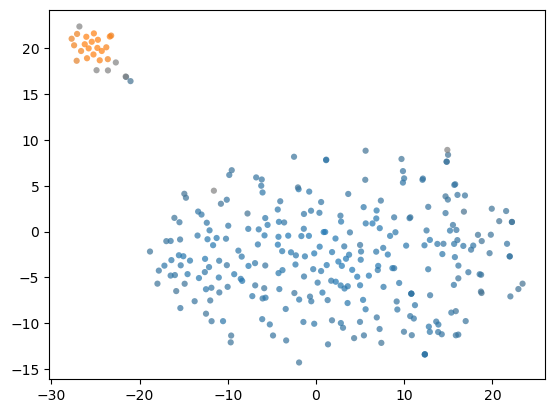

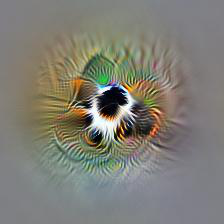

[0.18854423813101498, 19780, 13441]


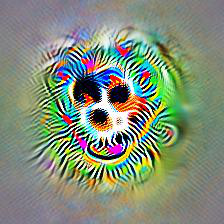

cluster 0 images: 273


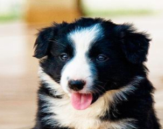

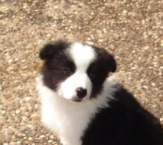

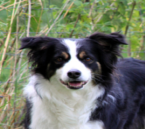

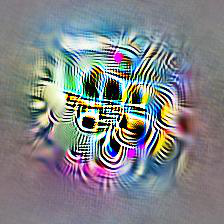

cluster 1 images: 20


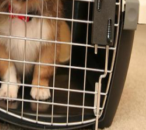

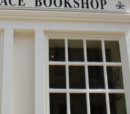

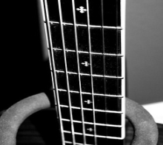




1057


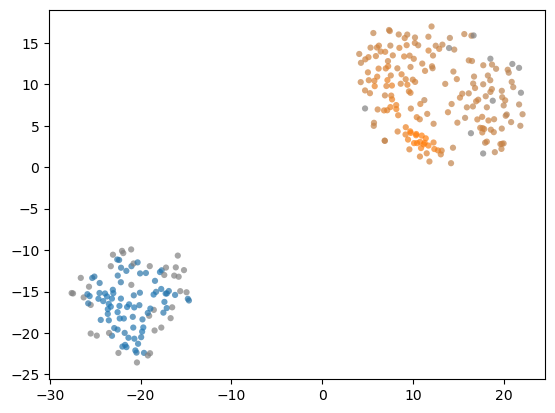

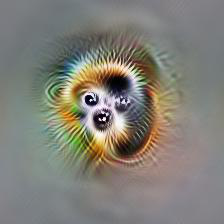

[0.2227025127394131, 18004, 16788]


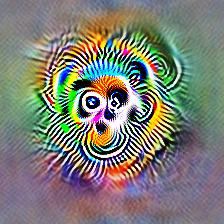

cluster 0 images: 77


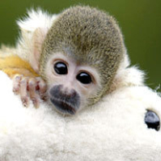

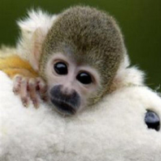

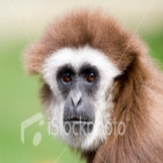

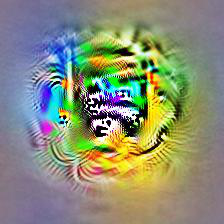

cluster 1 images: 177


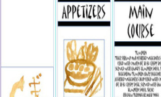

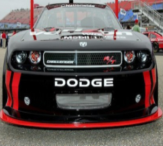

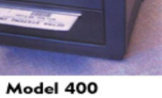




1063


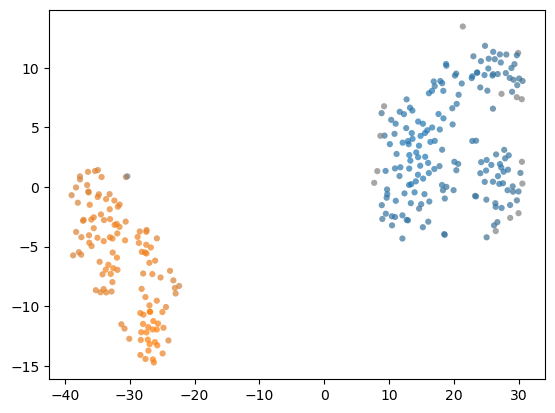

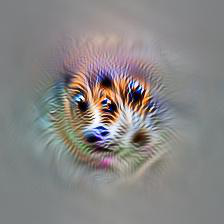

[0.20434736952640975, 17753, 16654]


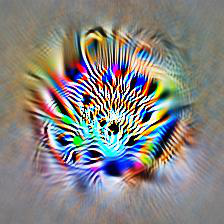

cluster 0 images: 167


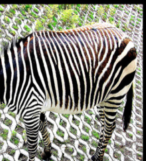

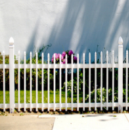

cluster 1 images: 118





1151


[0.1765408029284208, 14308, 15262]


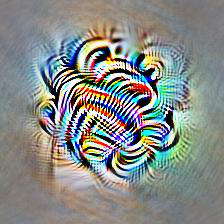

cluster 0 images: 230


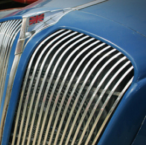

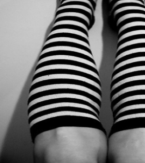

cluster 1 images: 64


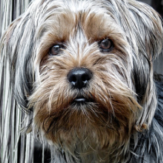

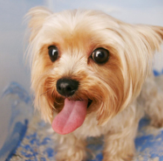

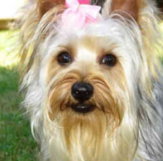

In [56]:
deepviz_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/visualizations/images/neuron/'
cluster_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/subneuron_max_activation_clusters/visualizations'

for nodeid,clusterer in enumerate(clusters):
    if 0 in clusterer.labels_ and nodeid in min_nodes:
        print(nodeid)

        patch_acts = pickle.load(open('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/maxpatch_layer_activations/'+str(nodeid)+'_top300.pkl','rb'))
        projection = TSNE().fit_transform(patch_acts)
        color_palette = sns.color_palette()
        cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
        plt.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.7)
        plt.show()
        
        #orig deepviz
        im = Image.open(deepviz_folder+str(nodeid)+'.jpg')
        display(im)
        
        
        #overlap
        print(overlap_dict[nodeid])
        
        layer_num,unit,layer_full_name = nodeid_2_perlayerid(nodeid,params)
        layer = 'conv'+str(layer_num)

        select_data_acts = max_activations['layer']['conv'+str(layer_num)][0][:,unit]
        select_data_positions = max_activations['layer']['conv'+str(layer_num)][1][:,unit,:]

        top_activations = torch.topk(torch.DoubleTensor(select_data_acts),300)
        
        
        cluster_indices = {}
        for j in range(300):
            clust_i = int(clusterer.labels_[j])
            if clust_i >= 0:
                if clust_i not in cluster_indices.keys():
                    cluster_indices[clust_i] = [j]
                else:
                    cluster_indices[clust_i].append(j)
                    
        for clust in cluster_indices:
            #cluster deepviz image
            cluster_image_folder = cluster_folder+'/'+str(nodeid)+'_cluster'+str(clust)+'/neuron/'
            if not os.path.exists(cluster_image_folder):
                clust_name = str(nodeid)+'_cluster'+str(clust)+'.pt'
                gen_vizualizations_for_subgraph(root_dir+'/'+clust_name, params)
                
            ims = os.listdir(cluster_image_folder)
            im = Image.open(cluster_image_folder+ims[0])
            display(im)
            
            
            print('cluster %s images: %s'%(str(clust),str(len(cluster_indices[clust]))))
            count = 0
            for ind in cluster_indices[clust]:
                if count < 3:
                    image_path = max_activations['image_folder']+'/'+image_names[int(top_activations.indices[ind])]
                    position = (int(select_data_positions[top_activations.indices[ind],0]),int(select_data_positions[top_activations.indices[ind],1]))
                    #print(select_data_acts[top_activations.indices[ind]])
                    display_image_patch_for_activation(image_path,layer,position,params,frame=False)
                    print('\n\n')
                    count += 1

            
        